Shape: (100000, 10)
Cluster 40: candidate = 663.7440535694024
Cluster 138: candidate = 664.7738876460135
Cluster 2: candidate = 1072.0284811222232
Cluster 114: candidate = 666.6
Cluster 110: candidate = 670.1669900999926
Cluster 49: candidate = 822.2524616204735
Cluster 6: candidate = 1482.5520582276397
Cluster 94: candidate = 672.8941961332749
Cluster 107: candidate = 821.5237647591201
Cluster 109: candidate = 494.81278523520723
Cluster 78: candidate = 667.5466422465472
Cluster 44: candidate = 666.3040235299696
Cluster 77: candidate = 670.2953456118279
Cluster 140: candidate = 565.7416311003683
Cluster 121: candidate = 491.46312581621356
Cluster 71: candidate = 667.5250881098366
Cluster 39: candidate = 819.8901724142547
Cluster 75: candidate = 568.4088243520783
Cluster 101: candidate = 431.43356242302605
Cluster 19: candidate = 1071.4666302264632
Cluster 132: candidate = 440.54388011095773
Cluster 108: candidate = 490.6178405125214
Cluster 118: candidate = 491.55787841146054
Cluster 6

<ipython-input-98-87d817eb524c>:326: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('viridis', num_labels)


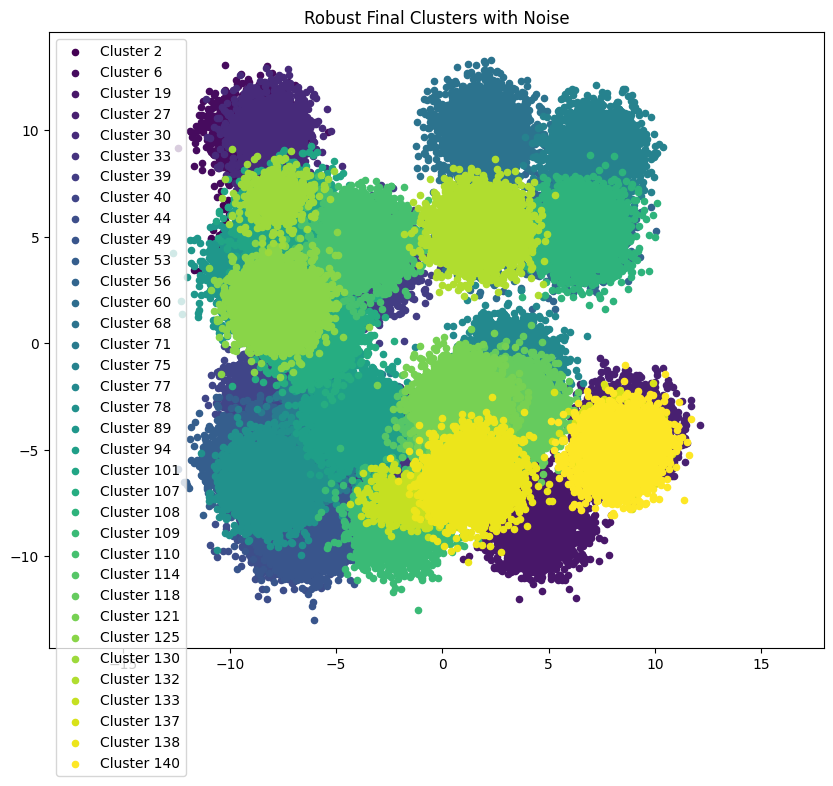

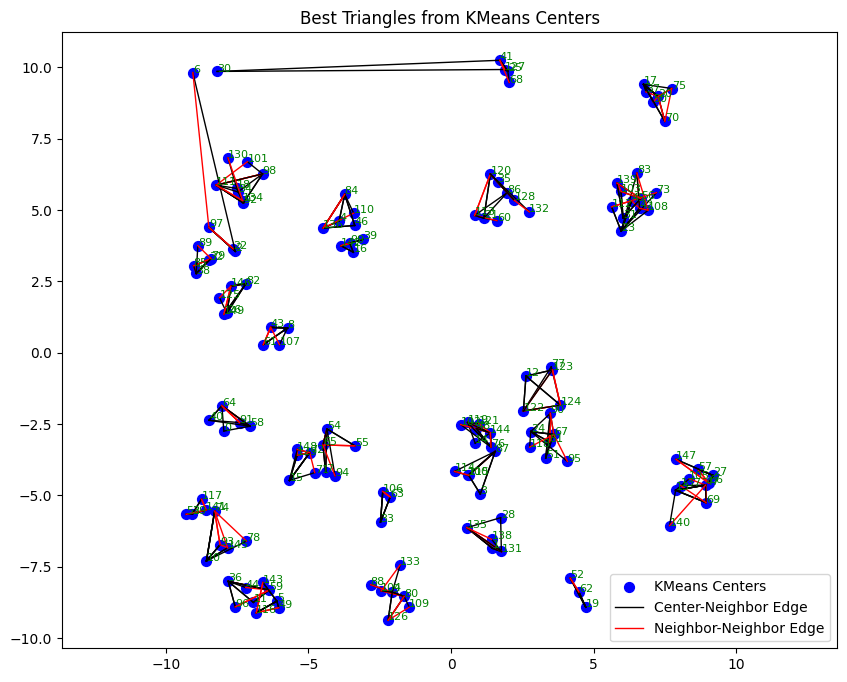

In [ ]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
import matplotlib.cm as cm
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

def batched_cdist(A, B, batch_size=None):
    """
    Computes the Euclidean distance between each pair of the two collections of inputs,
    optionally using batching to limit memory usage.
    """
    if batch_size is None:
        # Process everything at once.
        return np.linalg.norm(A[:, None] - B[None, :], axis=2)

    m = A.shape[0]
    n = B.shape[0]
    distances = np.empty((m, n), dtype=np.float64)
    for i in range(0, m, batch_size):
        end = min(i + batch_size, m)
        distances[i:end] = np.linalg.norm(A[i:end, None] - B[None, :], axis=2)
    return distances


def lightweight_kmeans(X, n_clusters, max_iter=10, random_state=42):
    """
    A lightweight KMeans center-finding implementation.
    Uses k-means++ initialization and a fixed number of Lloyd iterations.
    """
    np.random.seed(random_state)
    n_samples = X.shape[0]

    # --- k-means++ initialization ---
    centers = []
    first_center = X[np.random.randint(n_samples)]
    centers.append(first_center)

    for _ in range(1, n_clusters):
        dist_sq = np.min(cdist(X, np.array(centers)) ** 2, axis=1)
        try:
            probs = dist_sq / np.sum(dist_sq)
        except ZeroDivisionError:
            probs = np.inf
        cumulative_probs = np.cumsum(probs)
        r = np.random.rand()
        next_center = X[np.searchsorted(cumulative_probs, r)]
        centers.append(next_center)
    centers = np.array(centers)

    # --- Lloyd iterations ---
    for _ in range(max_iter):
        distances = cdist(X, centers)
        labels = np.argmin(distances, axis=1)
        new_centers = np.array([X[labels == i].mean(axis=0) if np.any(labels == i) else centers[i]
                                for i in range(n_clusters)])
        if np.allclose(centers, new_centers):
            break
        centers = new_centers

    return centers, labels


class RT:
    def __init__(self,
                 n_kmeans_clusters=200,
                 k=5,
                 alpha=1.0,
                 sparse_alpha=1.0,
                 min_cluster_size=10,  # Renamed parameter & now used as threshold.
                 gamma=2.3,
                 ratio_threshold=1,
                 beta=1.0,
                 random_state=42,
                 batch_size=None):
        """
        Parameters:
            n_kmeans_clusters: Number of clusters for the initial center finding.
            k: Number of neighbors to consider when searching for the best triangle.
            alpha: Factor for local std when computing the adaptive threshold.
            sparse_alpha: Factor used to filter sparse centers.
            min_cluster_size: Dynamic minimum cluster size threshold.
            gamma: Factor used in noise detection.
            ratio_threshold: Threshold used in the competing centers noise check.
            beta: Weight for the edge between the two neighbors (d(b,c)).
            random_state: Seed for reproducibility.
            batch_size: Batch size for distance computations.
        """
        self.n_kmeans_clusters = n_kmeans_clusters
        self.k = k
        self.alpha = alpha
        self.sparse_alpha = sparse_alpha
        self.min_cluster_size = min_cluster_size
        self.gamma = gamma
        self.ratio_threshold = ratio_threshold
        self.beta = beta
        self.random_state = random_state
        self.batch_size = batch_size

        # Attributes set during fitting.
        self.points = None
        self.kmeans_centers = None
        self.kmeans_labels = None
        self.final_labels = None
        self.final_labels_noise = None
        self.center_to_final_cluster = None
        self.cluster_thresholds = None
        self.center_triangle = None
        self.best_costs = None
        self.old_to_new_center_map = None

    def fit_predict(self, points):
        self.points = points

        # --- Step 1: Lightweight KMeans Clustering ---
        original_kmeans_centers, original_kmeans_labels = lightweight_kmeans(
            points, self.n_kmeans_clusters, max_iter=10, random_state=self.random_state)

        # --- Step 1.5: Filter Out Sparse Centers and Reassign Points ---
        nbrs_for_centers = NearestNeighbors(n_neighbors=self.k + 1).fit(original_kmeans_centers)
        dists_for_centers, _ = nbrs_for_centers.kneighbors(original_kmeans_centers)
        avg_dists = np.mean(dists_for_centers[:, 1:], axis=1)
        median_dist = np.median(avg_dists)
        std_dist = np.std(avg_dists)
        threshold_dist = median_dist + self.sparse_alpha * std_dist

        dense_mask = avg_dists <= threshold_dist
        dense_indices = np.where(dense_mask)[0]
        self.old_to_new_center_map = {old_idx: new_idx for new_idx, old_idx in enumerate(dense_indices)}
        self.kmeans_centers = original_kmeans_centers[dense_mask]

        new_labels = np.empty_like(original_kmeans_labels)
        for i, label in enumerate(original_kmeans_labels):
            new_labels[i] = self.old_to_new_center_map.get(label, -1)
        points_to_reassign = np.where(new_labels == -1)[0]
        if points_to_reassign.size > 0:
            nbrs_dense = NearestNeighbors(n_neighbors=1).fit(self.kmeans_centers)
            _, indices = nbrs_dense.kneighbors(points[points_to_reassign])
            new_labels[points_to_reassign] = indices.flatten()
        self.kmeans_labels = new_labels
        center_point_counts = np.bincount(new_labels, minlength=len(self.kmeans_centers))
        # print(f"Filtered centers: kept {len(self.kmeans_centers)} out of {len(original_kmeans_centers)} based on sparsity.")

        # --- Step 2: Compute Best Triangles and Their Costs ---
        num_centers = len(self.kmeans_centers)
        k_neighbors = min(self.k, num_centers - 1)
        nbrs = NearestNeighbors(n_neighbors=k_neighbors + 1).fit(self.kmeans_centers)
        dists_centers, indices_centers = nbrs.kneighbors(self.kmeans_centers)

        center_triangle = {}
        best_costs = np.empty(num_centers)
        for i in range(num_centers):
            neighbors = indices_centers[i, 1:]
            neighbor_dists = dists_centers[i, 1:]
            best_cost = np.inf
            best_tri = None
            for a, b in itertools.combinations(range(len(neighbors)), 2):
                d_ab = neighbor_dists[a]
                d_ac = neighbor_dists[b]
                d_bc = np.linalg.norm(self.kmeans_centers[neighbors[a]] - self.kmeans_centers[neighbors[b]])
                cost = d_ab + d_ac + self.beta * d_bc
                if cost < best_cost:
                    best_cost = cost
                    best_tri = (i, neighbors[a], neighbors[b])
            best_costs[i] = best_cost
            center_triangle[i] = tuple(sorted(best_tri))
        self.center_triangle = center_triangle
        self.best_costs = best_costs.tolist()
        enhanced_costs = best_costs

        # --- Step 2b: Compute Adaptive Local Thresholds using batched distances ---
        full_dists = batched_cdist(self.kmeans_centers, self.kmeans_centers, batch_size=self.batch_size)
        np.fill_diagonal(full_dists, np.inf)
        sorted_indices = np.argsort(full_dists, axis=1)[:, :self.k]
        local_thresholds = np.empty(num_centers)
        for i in range(num_centers):
            local_costs = enhanced_costs[sorted_indices[i]]
            local_thresholds[i] = np.median(local_costs) + self.alpha * np.std(local_costs)

        # --- Step 3: Merge Centers Using Union-Find ---
        parent = list(range(num_centers))
        def find(x):
            if parent[x] != x:
                parent[x] = find(parent[x])
            return parent[x]
        def union(x, y):
            rx, ry = find(x), find(y)
            if rx != ry:
                parent[ry] = rx
        for i, triangle in self.center_triangle.items():
            if enhanced_costs[i] <= local_thresholds[i]:
                for v in triangle:
                    union(i, v)
        merged_clusters_centers = {}
        for i in range(num_centers):
            root = find(i)
            merged_clusters_centers.setdefault(root, []).append(i)

        # --- Step 4: Compute Candidate Values and Enforce Strict Rule ---
        # Build the mapping from each kmeans center (index) to its final cluster.
        self.center_to_final_cluster = {}
        for final_label, idx_list in merged_clusters_centers.items():
            for idx in idx_list:
                self.center_to_final_cluster[idx] = final_label
        # Assign each point its final cluster (based on its associated kmeans center).
        final_point_labels = np.array([self.center_to_final_cluster.get(label, label)
                                        for label in self.kmeans_labels])
        self.final_labels = final_point_labels.copy()

        # Compute cluster densities: average distance of points to their assigned kmeans center.
        cluster_densities = {}
        for cluster, center_indices in merged_clusters_centers.items():
            cluster_points_idx = np.where(final_point_labels == cluster)[0]
            centers_for_points = self.kmeans_centers[self.kmeans_labels[cluster_points_idx]]
            dists = np.linalg.norm(self.points[cluster_points_idx] - centers_for_points, axis=1)
            cluster_densities[cluster] = np.mean(dists) if dists.size > 0 else np.inf

        # Global median density over clusters
        global_median_density = np.median(list(cluster_densities.values()))
        candidate_values = {}
        for cluster, center_list in merged_clusters_centers.items():
            points_i = np.sum(final_point_labels == cluster)
            kmeans_i = len(center_list)
            density_i = cluster_densities[cluster]
            candidate_i = (points_i / kmeans_i) * (global_median_density / density_i)
            candidate_values[cluster] = candidate_i
            print(f"Cluster {cluster}: candidate = {candidate_i}")

        # Identify valid clusters (candidate >= threshold) and small clusters.
        valid_final_clusters = [cluster for cluster, cand in candidate_values.items()
                                if cand >= self.min_cluster_size]
        small_final_clusters = [cluster for cluster, cand in candidate_values.items()
                                if cand < self.min_cluster_size]

        # --- Strict Rule: Reassign all points from small clusters to nearest valid cluster.
        if valid_final_clusters:
            # Build a mask of kmeans centers that belong to valid clusters.
            valid_kmeans_indices = [idx for idx, cl in self.center_to_final_cluster.items()
                                    if cl in valid_final_clusters]
            valid_centers = self.kmeans_centers[valid_kmeans_indices]
            nbrs_valid = NearestNeighbors(n_neighbors=1).fit(valid_centers)

            # For each point belonging to a small final cluster, find the nearest valid center.
            for i in range(len(final_point_labels)):
                if final_point_labels[i] in small_final_clusters:
                    # Find nearest valid kmeans center.
                    point = self.points[i].reshape(1, -1)
                    dist, idx = nbrs_valid.kneighbors(point)
                    # Get the original kmeans center index of the nearest valid center.
                    nearest_valid_kmeans_idx = valid_kmeans_indices[idx[0][0]]
                    # Reassign the point to the final cluster of that kmeans center.
                    final_point_labels[i] = self.center_to_final_cluster[nearest_valid_kmeans_idx]
        self.final_labels = final_point_labels.copy()

        # --- Step 5: Noise Detection Based on Distance to KMeans Centers ---
        final_point_labels_noise = final_point_labels.copy()
        non_noise_mask = final_point_labels != -1
        non_noise_idx = np.nonzero(non_noise_mask)[0]
        centers_for_points = self.kmeans_centers[self.kmeans_labels[non_noise_idx]]
        dists = np.linalg.norm(self.points[non_noise_idx] - centers_for_points, axis=1)
        cluster_labels = final_point_labels[non_noise_idx]
        unique_clusters, inverse = np.unique(cluster_labels, return_inverse=True)
        cluster_sums = np.bincount(inverse, weights=dists)
        cluster_counts = np.bincount(inverse)
        cluster_means = cluster_sums / cluster_counts
        thresholds = cluster_means[inverse] * self.gamma
        noise_flags = dists > thresholds
        final_point_labels_noise[non_noise_idx[noise_flags]] = -1

        # --- Step 6: Additional Noise Check Based on Competing Centers ---
        valid_mask = final_point_labels_noise != -1
        if np.any(valid_mask):
            valid_idx = np.nonzero(valid_mask)[0]
            valid_points = self.points[valid_idx]
            all_dists = batched_cdist(valid_points, self.kmeans_centers, batch_size=self.batch_size)
            partitioned = np.argpartition(all_dists, kth=1, axis=1)[:, :2]
            sorted_order = np.argsort(np.take_along_axis(all_dists, partitioned, axis=1), axis=1)
            nearest_two = np.take_along_axis(partitioned, sorted_order, axis=1)
            d1 = np.take_along_axis(all_dists, nearest_two[:, [0]], axis=1).flatten()
            d2 = np.take_along_axis(all_dists, nearest_two[:, [1]], axis=1).flatten()
            ratios = d1 / (d2 + 1e9)
            ratio_condition = ratios > self.ratio_threshold
            idx1 = nearest_two[:, 0]
            idx2 = nearest_two[:, 1]
            cl1 = np.array([self.center_to_final_cluster.get(int(idx), int(idx)) for idx in idx1])
            cl2 = np.array([self.center_to_final_cluster.get(int(idx), int(idx)) for idx in idx2])
            competing_condition = cl1 != cl2
            noise_points = ratio_condition & competing_condition
            final_point_labels_noise[valid_idx[noise_points]] = -1

        # --- Step 7: Store Cluster Thresholds ---
        non_noise_mask2 = final_point_labels != -1
        non_noise_idx2 = np.nonzero(non_noise_mask2)[0]
        centers_for_points2 = self.kmeans_centers[self.kmeans_labels[non_noise_idx2]]
        dists2 = np.linalg.norm(self.points[non_noise_idx2] - centers_for_points2, axis=1)
        cluster_labels2 = final_point_labels[non_noise_idx2]
        unique_clusters2, inverse2 = np.unique(cluster_labels2, return_inverse=True)
        sums2 = np.bincount(inverse2, weights=dists2)
        counts2 = np.bincount(inverse2)
        means2 = sums2 / counts2
        self.cluster_thresholds = {cluster: self.gamma * mean
                                  for cluster, mean in zip(unique_clusters2, means2)}

        self.final_labels_noise = final_point_labels_noise
        print(len(np.unique(self.final_labels_noise)))
        return self.final_labels_noise

    def predict(self, points, apply_noise_detection=True):
        predicted_labels = np.empty(len(points), dtype=int)
        for i, p in enumerate(points):
            dists = np.linalg.norm(self.kmeans_centers - p, axis=1)
            nearest_idx = np.argmin(dists)
            label = self.center_to_final_cluster.get(nearest_idx, nearest_idx)
            if apply_noise_detection and label in self.cluster_thresholds:
                if dists[nearest_idx] > self.cluster_thresholds[label]:
                    label = -1
            predicted_labels[i] = label
        return predicted_labels

    def plot_clusters(self, use_noise=True, figsize=(10, 8)):
        if self.points is None:
            raise ValueError("Model has not been fitted.")
        labels = self.final_labels_noise if use_noise else self.final_labels
        unique_labels = np.unique(labels)
        num_labels = len(unique_labels)
        color_map = cm.get_cmap('viridis', num_labels)
        colors = {lbl: (0, 0, 0, 1) if lbl == -1 else color_map(i / (num_labels - 1))
                  for i, lbl in enumerate(sorted(unique_labels))}
        plt.figure(figsize=figsize)
        for lbl in unique_labels:
            pts = self.points[labels == lbl]
            label_str = "Noise" if lbl == -1 else f"Cluster {lbl}"
            plt.scatter(pts[:, 0], pts[:, 1], color=colors[lbl], s=20, label=label_str, zorder=3)
        plt.title("Robust Final Clusters" + (" with Noise" if use_noise else ""))
        plt.legend()
        plt.axis('equal')
        plt.show()

    def plot_best_triangles(self, figsize=(16, 12)):
        if self.kmeans_centers is None or self.center_triangle is None:
            raise ValueError("Model must be fitted before plotting best triangles.")
        plt.figure(figsize=figsize)
        plt.scatter(self.kmeans_centers[:, 0], self.kmeans_centers[:, 1],
                    color='blue', s=50, label='KMeans Centers')
        for i, triangle in self.center_triangle.items():
            pts = self.kmeans_centers[list(triangle)]
            center_pt, neighbor1_pt, neighbor2_pt = pts[0], pts[1], pts[2]
            plt.plot([center_pt[0], neighbor1_pt[0]], [center_pt[1], neighbor1_pt[1]],
                     color='black', linewidth=1, label='Center-Neighbor Edge' if i == 0 else "")
            plt.plot([center_pt[0], neighbor2_pt[0]], [center_pt[1], neighbor2_pt[1]],
                     color='black', linewidth=1)
            plt.plot([neighbor1_pt[0], neighbor2_pt[0]], [neighbor1_pt[1], neighbor2_pt[1]],
                     color='red', linewidth=1, label='Neighbor-Neighbor Edge' if i == 0 else "")
            plt.text(self.kmeans_centers[i, 0], self.kmeans_centers[i, 1], str(i),
                     fontsize=8, color='green')
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys())
        plt.title("Best Triangles from KMeans Centers")
        plt.axis('equal')
        plt.show()

    @staticmethod
    def generate_arbitrary_clusters(n_samples=10000, noise=0.01, random_state=42):
        from sklearn.datasets import make_moons, make_circles, make_blobs
        np.random.seed(random_state)
        moons, _ = make_moons(n_samples=n_samples // 3, noise=noise)
        circles, _ = make_circles(n_samples=n_samples // 3, noise=noise, factor=0.5)
        blobs, _ = make_blobs(n_samples=n_samples // 3,
                               centers=[(2, 2), (-2, -2)],
                               cluster_std=[0.5, 0.5])
        return np.vstack([moons, circles + 10, blobs])


if __name__ == "__main__":
    import time
    from sklearn.metrics import adjusted_rand_score
    from sklearn.datasets import make_blobs

    # Example: using high-dimensional blobs.
    points, y = make_blobs(n_samples=100000, n_features=10, centers=30, random_state=170)

    rtc = RT(
        n_kmeans_clusters=150,
        k=5,
        alpha=2,
        sparse_alpha=10,
        min_cluster_size=5,  # Dynamic threshold for candidate values.
        gamma=3,
        beta=5,
        ratio_threshold=1,
        random_state=42,
        batch_size=None  # Set to None for no batching, or a number for batched processing.
    )

    print("Shape:", points.shape)
    start_time = time.time()
    rtc.fit_predict(points)
    print("Time taken:", time.time() - start_time)
    print("Adjusted Rand Score:", adjusted_rand_score(y.flatten(), rtc.final_labels))

    # Optionally, plot clusters and best triangles (for lower-dimensional datasets).
    rtc.plot_clusters(use_noise=True)
    rtc.plot_best_triangles(figsize=(10, 8))


In [ ]:
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import scipy.io
import os
import time
from sklearn.datasets import make_blobs, make_moons, make_circles

def generate_datasets(mat_folder_path="/content/"):
    """
    Generates a list of datasets for comparison, including synthetic and .mat datasets
    from a specified folder.
    """
    datasets = []

    # Synthetic Datasets
    X_blobs_iso, y_blobs_iso = make_blobs(n_samples=10000, random_state=170, centers=3)
    datasets.append({'name': 'Blobs (Isotropic)', 'data': X_blobs_iso, 'ground_truth': y_blobs_iso})

    X_blobs_aniso, y_blobs_aniso = make_blobs(n_samples=10000, random_state=170, centers=3)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_blobs_aniso = np.dot(X_blobs_aniso, transformation)
    datasets.append({'name': 'Blobs (Anisotropic)', 'data': X_blobs_aniso, 'ground_truth': y_blobs_aniso})

    X_moons, y_moons = make_moons(n_samples=10000, noise=0.05, random_state=170)
    datasets.append({'name': 'Moons', 'data': X_moons, 'ground_truth': y_moons})

    X_circles, y_circles = make_circles(n_samples=10000, factor=0.5, noise=0.05, random_state=170)
    datasets.append({'name': 'Circles', 'data': X_circles, 'ground_truth': y_circles})

    # Complex9 (if exists)
    # try:
    #     data_complex9 = scipy.io.loadmat('complex9.mat')
    #     X_complex9, y_complex9 = data_complex9['data'], data_complex9['label']
    #     X_complex9 = StandardScaler().fit_transform(X_complex9)
    #     datasets.append({'name': 'Complex9', 'data': X_complex9, 'ground_truth': y_complex9.flatten()})
    # except FileNotFoundError:
    #     print("Warning: complex9.mat not found, skipping Complex9 dataset.")

    # Additional .mat datasets from folder
    if not os.path.exists(mat_folder_path):
        print(f"Warning: Folder '{mat_folder_path}' not found. Skipping .mat datasets.")
    else:
        mat_files = [f for f in os.listdir(mat_folder_path) if f.endswith('.mat')]
        if not mat_files:
            print(f"Warning: No .mat files found in '{mat_folder_path}'.")
        else:
            print(f"Loading .mat datasets from folder: '{mat_folder_path}'")
            for mat_file in mat_files:
                file_path = os.path.join(mat_folder_path, mat_file)
                try:
                    data_mat = scipy.io.loadmat(file_path)
                    points_mat = data_mat.get('data')
                    labels_mat = data_mat.get('label')
                    if points_mat is None or labels_mat is None:
                        print(f"  Warning: Could not load 'data' or 'label' from '{mat_file}'. Skipping.")
                        continue
                    if points_mat.ndim == 1:
                        points_mat = np.array(points_mat).reshape(-1, 1)
                    if labels_mat.ndim > 1:
                        labels_mat = labels_mat.flatten()
                    points_mat = StandardScaler().fit_transform(points_mat)
                    dataset_name = os.path.splitext(mat_file)[0]
                    datasets.append({'name': dataset_name, 'data': points_mat, 'ground_truth': labels_mat})
                    print(f"  Loaded dataset: {dataset_name} from '{mat_file}'")
                except Exception as e:
                    print(f"  Error loading '{mat_file}': {e}. Skipping.")
    return datasets

# -------------------------
# Function to Run and Evaluate Clustering Algorithms
# -------------------------
def run_clustering_and_evaluate(dataset_name, points, ground_truth, rtc_params):
    """
    Runs several clustering algorithms on the dataset and prints runtime and evaluation metrics:
      - Silhouette Score
      - Adjusted Rand Index (if ground truth is provided)
      - Davies–Bouldin Score
    """
    print(f"\n=== Dataset: {dataset_name} ===")

    results = {}

    # Helper function to compute metrics
    def compute_metrics(labels, algo_name):
        metrics = {}
        unique_labels = np.unique(labels)
        if len(unique_labels) > 1:
            metrics['silhouette'] = silhouette_score(points, labels)
            metrics['davies'] = davies_bouldin_score(points, labels)
        else:
            metrics['silhouette'] = 0
            metrics['davies'] = np.inf
        if ground_truth is not None:
            try:
                metrics['ARI'] = adjusted_rand_score(ground_truth, labels)
            except Exception:
                metrics['ARI'] = None
        else:
            metrics['ARI'] = None
        print(f"  {algo_name} -> Silhouette: {metrics['silhouette']:.4f}, "
              f"Davies: {metrics['davies']:.4f}, ARI: {metrics['ARI']}")
        return metrics

    # 1. RobustTriangleClusterer (RTC)
    print("\nRobustTriangleClusterer:")
    rtc = RT(**rtc_params)
    start = time.time()
    rtc.fit_predict(points)
    elapsed = time.time() - start
    rtc_labels = rtc.final_labels
    # print(f"  Runtime: {elapsed:.4f} sec")
    rtc_metrics = compute_metrics(rtc_labels, "RTC")
    results['RTC'] = (rtc_labels, elapsed, rtc_metrics)

    # 2. KMeans
    print("\nKMeans:")
    kmeans = KMeans()
    start = time.time()
    kmeans_labels = kmeans.fit_predict(points)
    elapsed = time.time() - start
    # print(f"  Runtime: {elapsed:.4f} sec")
    kmeans_metrics = compute_metrics(kmeans_labels, "KMeans")
    results['KMeans'] = (kmeans_labels, elapsed, kmeans_metrics)

    # 3. Agglomerative Clustering
    print("\nAgglomerativeClustering:")
    agglo = AgglomerativeClustering()
    start = time.time()
    agglo_labels = agglo.fit_predict(points)
    elapsed = time.time() - start
    # print(f"  Runtime: {elapsed:.4f} sec")
    agglo_metrics = compute_metrics(agglo_labels, "Agglomerative")
    results['Agglomerative'] = (agglo_labels, elapsed, agglo_metrics)

    # 4. DBSCAN
    print("\nDBSCAN:")
    dbscan = DBSCAN()
    start = time.time()
    dbscan_labels = dbscan.fit_predict(points)
    elapsed = time.time() - start
    # print(f"  Runtime: {elapsed:.4f} sec")
    dbscan_metrics = compute_metrics(dbscan_labels, "DBSCAN")
    results['DBSCAN'] = (dbscan_labels, elapsed, dbscan_metrics)

    # 5. HDBSCAN
    # print("\nHDBSCAN:")
    # hdb = hdbscan.HDBSCAN()
    # start = time.time()
    # hdb_labels = hdb.fit_predict(points)
    # elapsed = time.time() - start
    # print(f"  Runtime: {elapsed:.4f} sec")
    # hdb_metrics = compute_metrics(hdb_labels, "HDBSCAN")
    # results['HDBSCAN'] = (hdb_labels, elapsed, hdb_metrics)

    # 6. Spectral Clustering
    print("\nSpectralClustering:")
    spec = SpectralClustering()
    start = time.time()
    spec_labels = spec.fit_predict(points)
    elapsed = time.time() - start
    print(f"  Runtime: {elapsed:.4f} sec")
    spec_metrics = compute_metrics(spec_labels, "Spectral")
    results['Spectral'] = (spec_labels, elapsed, spec_metrics)

    return results

# -------------------------
# Main Execution
# -------------------------
if __name__ == "__main__":
    # Set path to folder with .mat datasets (if any)
    mat_dataset_folder = "/content/"
    datasets = generate_datasets(mat_folder_path=mat_dataset_folder)

    # Default parameters for RTC (adjust as needed)
    default_rtc_params = {
       'n_kmeans_clusters': 10, 'k': 2, 'alpha': 10.0, 'sparse_alpha': 10, 'min_cluster_size': 1, 'gamma': 10, 'beta': -3, 'ratio_threshold': 1
    }

    # Loop over datasets and run comparisons
    for dataset in datasets:
        dataset_name = dataset['name']
        points = dataset['data']
        ground_truth = dataset['ground_truth']
        print(f"\n-------------------------\nDataset: {dataset_name}, shape: {points.shape}")
        run_clustering_and_evaluate(dataset_name, points, ground_truth, default_rtc_params)


Loading .mat datasets from folder: '/content/'
  Loaded dataset: aggregation from 'aggregation.mat'
  Loaded dataset: wpbc from 'wpbc.mat'
  Loaded dataset: balance from 'balance.mat'
  Loaded dataset: ionosphere from 'ionosphere.mat'
  Loaded dataset: wine from 'wine.mat'
  Loaded dataset: thyroid from 'thyroid.mat'
  Loaded dataset: iris from 'iris.mat'
  Loaded dataset: wineqr from 'wineqr.mat'
  Loaded dataset: breast from 'breast.mat'
  Loaded dataset: biodeg from 'biodeg.mat'
  Loaded dataset: banknote from 'banknote.mat'
  Loaded dataset: segment from 'segment.mat'
  Loaded dataset: eeg from 'eeg.mat'
  Loaded dataset: seeds from 'seeds.mat'
  Loaded dataset: spambase from 'spambase.mat'
  Loaded dataset: pima from 'pima.mat'
  Loaded dataset: liver from 'liver.mat'
  Loaded dataset: msplice from 'msplice.mat'
  Loaded dataset: letter from 'letter.mat'
  Loaded dataset: ecoli from 'ecoli.mat'
  Loaded dataset: vote from 'vote.mat'
  Loaded dataset: vehicle from 'vehicle.mat'
  L

<ipython-input-2-dbe979af8aa6>:215: RuntimeWarning: invalid value encountered in scalar divide
  candidate_i = (points_i / kmeans_i) * (global_median_density / density_i)


Candidate values per cluster: {np.int64(43): np.float64(nan), np.int64(78): np.float64(nan), np.int64(139): np.float64(0.0)}
  RTC -> Silhouette: -0.0889, Davies: 0.8977, ARI: 0.0089695571281168

KMeans:
  KMeans -> Silhouette: 0.1177, Davies: 2.1222, ARI: 0.13349001845966468

AgglomerativeClustering:
  Agglomerative -> Silhouette: 0.2734, Davies: 1.6295, ARI: 0.19261656538532831

DBSCAN:
  DBSCAN -> Silhouette: -0.1554, Davies: 1.3912, ARI: -0.0358855886762454

SpectralClustering:
  Runtime: 0.0919 sec
  Spectral -> Silhouette: -0.0126, Davies: 1.2464, ARI: 0.04590297901624185

-------------------------
Dataset: wine, shape: (178, 13)

=== Dataset: wine ===

RobustTriangleClusterer:


<ipython-input-2-dbe979af8aa6>:215: RuntimeWarning: invalid value encountered in scalar divide
  candidate_i = (points_i / kmeans_i) * (global_median_density / density_i)
<ipython-input-2-dbe979af8aa6>:215: RuntimeWarning: invalid value encountered in scalar divide
  candidate_i = (points_i / kmeans_i) * (global_median_density / density_i)


Candidate values per cluster: {np.int64(20): np.float64(nan), np.int64(118): np.float64(nan), np.int64(142): np.float64(0.0)}
  RTC -> Silhouette: 0.0259, Davies: 1.4413, ARI: -0.002793121347049911

KMeans:
  KMeans -> Silhouette: 0.1784, Davies: 1.8075, ARI: 0.5039156180767819

AgglomerativeClustering:
  Agglomerative -> Silhouette: 0.2670, Davies: 1.4118, ARI: 0.43943910439476336

DBSCAN:
  DBSCAN -> Silhouette: 0.0000, Davies: inf, ARI: 0.0

SpectralClustering:
  Runtime: 0.0361 sec
  Spectral -> Silhouette: 0.0999, Davies: 1.4086, ARI: 0.7006830339088738

-------------------------
Dataset: thyroid, shape: (215, 5)

=== Dataset: thyroid ===

RobustTriangleClusterer:
Candidate values per cluster: {np.int64(8): np.float64(nan), np.int64(26): np.float64(nan), np.int64(27): np.float64(nan), np.int64(146): np.float64(0.0)}
  RTC -> Silhouette: 0.2643, Davies: 0.5949, ARI: 0.1362972977326942

KMeans:
  KMeans -> Silhouette: 0.3059, Davies: 1.0554, ARI: 0.3898598093549825

AgglomerativeClu

<ipython-input-2-dbe979af8aa6>:215: RuntimeWarning: invalid value encountered in scalar divide
  candidate_i = (points_i / kmeans_i) * (global_median_density / density_i)


Candidate values per cluster: {np.int64(149): np.float64(10.66)}
  RTC -> Silhouette: 0.0000, Davies: inf, ARI: 0.0

KMeans:
  KMeans -> Silhouette: 0.1823, Davies: 1.4963, ARI: 0.05878934001427302

AgglomerativeClustering:
  Agglomerative -> Silhouette: 0.1834, Davies: 2.0296, ARI: 0.08886283232719482

DBSCAN:
  DBSCAN -> Silhouette: -0.2505, Davies: 1.4124, ARI: -0.004378282038727852

SpectralClustering:
  Runtime: 3.0999 sec
  Spectral -> Silhouette: 0.2957, Davies: 0.5136, ARI: -0.001434007094749757

-------------------------
Dataset: breast, shape: (277, 9)

=== Dataset: breast ===

RobustTriangleClusterer:
Candidate values per cluster: {np.int64(35): np.float64(1.6696593008598632), np.int64(82): np.float64(2.0476190476190474), np.int64(140): np.float64(1.6924148110240504)}
  RTC -> Silhouette: 0.0439, Davies: 1.9861, ARI: 0.010616015077657597

KMeans:
  KMeans -> Silhouette: 0.1734, Davies: 1.6321, ARI: 0.023847951565790115

AgglomerativeClustering:
  Agglomerative -> Silhouette:

<ipython-input-2-dbe979af8aa6>:215: RuntimeWarning: divide by zero encountered in scalar divide
  candidate_i = (points_i / kmeans_i) * (global_median_density / density_i)


Candidate values per cluster: {np.int64(14): 0, np.int64(22): np.float64(1.7988379156815872), np.int64(37): np.float64(2.4762797799624794), np.int64(39): np.float64(1.7951620847590082), np.int64(86): np.float64(3.2078019330535414), np.int64(145): np.float64(6.717343893423222)}
  RTC -> Silhouette: 0.3082, Davies: 1.1264, ARI: -0.040097382426084356

KMeans:
  KMeans -> Silhouette: 0.1505, Davies: 1.6070, ARI: 0.059384635282128756

AgglomerativeClustering:
  Agglomerative -> Silhouette: 0.1026, Davies: 2.7916, ARI: 0.21623106029726663

DBSCAN:
  DBSCAN -> Silhouette: -0.1499, Davies: 1.3865, ARI: -0.0054590389339846754

SpectralClustering:


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


  Runtime: 70.2077 sec
  Spectral -> Silhouette: 0.3840, Davies: 1.0930, ARI: -0.012485947163165373

-------------------------
Dataset: banknote, shape: (1372, 4)

=== Dataset: banknote ===

RobustTriangleClusterer:
Candidate values per cluster: {np.int64(103): np.float64(7.887908830376967), np.int64(141): np.float64(11.40624838813024)}
  RTC -> Silhouette: 0.1967, Davies: 0.8007, ARI: -0.0099211041634194

KMeans:
  KMeans -> Silhouette: 0.2983, Davies: 1.0447, ARI: 0.17848398958665718

AgglomerativeClustering:
  Agglomerative -> Silhouette: 0.3130, Davies: 1.2270, ARI: 0.03475259826611058

DBSCAN:
  DBSCAN -> Silhouette: -0.0375, Davies: 1.1474, ARI: 0.006124788692159121

SpectralClustering:
  Runtime: 0.3330 sec
  Spectral -> Silhouette: 0.2930, Davies: 0.9759, ARI: 0.2788706058417328

-------------------------
Dataset: segment, shape: (2310, 18)

=== Dataset: segment ===

RobustTriangleClusterer:
Candidate values per cluster: {np.int64(1): np.float64(6.56766489706754), np.int64(51):

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


  Runtime: 40.9165 sec
  Spectral -> Silhouette: 0.8214, Davies: 0.1260, ARI: 0.0

-------------------------
Dataset: eeg, shape: (14980, 14)

=== Dataset: eeg ===

RobustTriangleClusterer:


<ipython-input-2-dbe979af8aa6>:215: RuntimeWarning: invalid value encountered in scalar divide
  candidate_i = (points_i / kmeans_i) * (global_median_density / density_i)


Candidate values per cluster: {np.int64(1): np.float64(nan), np.int64(2): np.float64(nan), np.int64(3): np.float64(nan), np.int64(4): np.float64(nan), np.int64(146): np.float64(0.0)}
  RTC -> Silhouette: 0.9895, Davies: 0.0061, ARI: -4.3949007970207816e-05

KMeans:
  KMeans -> Silhouette: 0.2046, Davies: 0.6427, ARI: 0.004182946104442069

AgglomerativeClustering:
  Agglomerative -> Silhouette: 0.9923, Davies: 0.0052, ARI: 3.046345867582477e-05

DBSCAN:
  DBSCAN -> Silhouette: 0.2194, Davies: 2.6217, ARI: -0.0035279182032934763

SpectralClustering:


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


  Runtime: 102.7934 sec
  Spectral -> Silhouette: 0.4188, Davies: 0.7707, ARI: -0.0025674482116300945

-------------------------
Dataset: seeds, shape: (210, 7)

=== Dataset: seeds ===

RobustTriangleClusterer:
Candidate values per cluster: {np.int64(9): np.float64(12.491532481076938), np.int64(84): np.float64(0.7066202458737312)}
  RTC -> Silhouette: 0.0000, Davies: inf, ARI: 0.0

KMeans:
  KMeans -> Silhouette: 0.2940, Davies: 0.9889, ARI: 0.4305890458146745

AgglomerativeClustering:
  Agglomerative -> Silhouette: 0.5207, Davies: 0.7328, ARI: 0.49685887767860626

DBSCAN:
  DBSCAN -> Silhouette: -0.1330, Davies: 1.7186, ARI: 0.19635708773799757

SpectralClustering:
  Runtime: 0.0334 sec
  Spectral -> Silhouette: 0.7882, Davies: 0.1563, ARI: 0.0

-------------------------
Dataset: spambase, shape: (4601, 57)

=== Dataset: spambase ===

RobustTriangleClusterer:


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-2-dbe979af8aa6>:215: RuntimeWarning: divide by zero encountered in scalar divide
  candidate_i = (points_i / kmeans_i) * (global_median_density / density_i)


Candidate values per cluster: {np.int64(9): 0, np.int64(11): np.float64(1.2318691254645961), np.int64(38): np.float64(4.627253450888963), np.int64(39): np.float64(5.988036313976421), np.int64(83): 0, np.int64(148): np.float64(34.4841506558695)}
  RTC -> Silhouette: 0.4114, Davies: 0.7528, ARI: -0.0012091876726502174

KMeans:
  KMeans -> Silhouette: 0.1031, Davies: 2.1142, ARI: 0.2748468899077978

AgglomerativeClustering:
  Agglomerative -> Silhouette: 0.6660, Davies: 0.6096, ARI: -0.004810540396605019

DBSCAN:
  DBSCAN -> Silhouette: -0.2715, Davies: 1.3103, ARI: 0.01151537993537665

SpectralClustering:


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Loaded dataset: compound from 'compound.mat'
Loaded dataset: donut3 from 'donut3.mat'
Loaded dataset: spiralsquare from 'spiralsquare.mat'
Loaded dataset: smile2 from 'smile2.mat'
Loaded dataset: twenty from 'twenty.mat'
Loaded dataset: pearl from 'pearl.mat'
Loaded dataset: S1 from 'S1.mat'
Loaded dataset: S3 from 'S3.mat'
Loaded dataset: curves2 from 'curves2.mat'
Loaded dataset: twomoon from 'twomoon.mat'
Loaded dataset: 2spiral from '2spiral.mat'
Loaded dataset: S2 from 'S2.mat'
Loaded dataset: target from 'target.mat'
Loaded dataset: donutcurves from 'donutcurves.mat'
Loaded dataset: spiral from 'spiral.mat'
Loaded dataset: D31 from 'D31.mat'
Loaded dataset: 3MC from '3MC.mat'
Loaded dataset: curves1 from 'curves1.mat'
Loaded dataset: zelink1 from 'zelink1.mat'
Loaded dataset: flame from 'flame.mat'
Loaded dataset: aggregation from 'aggregation.mat'
Loaded dataset: R15 from 'R15.mat'
Loaded dataset: dartboard1 from 'dartboard1.mat'
Loaded dataset: cure-t2-4k from 'cure-t2-4k.mat'


<ipython-input-1-dbe979af8aa6>:215: RuntimeWarning: divide by zero encountered in scalar divide
  candidate_i = (points_i / kmeans_i) * (global_median_density / density_i)


Candidate values per cluster: {np.int64(2): 0, np.int64(7): np.float64(3.5767403199367576), np.int64(56): np.float64(2.493142672132338), np.int64(71): np.float64(11.160764146192253), np.int64(79): np.float64(1.4877408457053434), np.int64(87): np.float64(1.6630846188263184), np.int64(104): np.float64(3.5909454106560554), np.int64(125): np.float64(13.346564783869386)}
  BEXMAN: ARI = 0.6242
  KMeans: ARI = 0.3496
  Agglomerative: ARI = 0.2516
  DBSCAN: ARI = 0.9996
  Spectral: ARI = 0.7007
  Birch: ARI = 0.2590
  GaussianMixture: ARI = 0.0000

Processing synthetic dataset: donutcurves
Candidate values per cluster: {np.int64(12): np.float64(3.8859830950109804), np.int64(22): np.float64(2.598305264420821), np.int64(33): np.float64(4.234221092551254), np.int64(39): np.float64(7.715473007954616), np.int64(41): np.float64(44.73705545343436), np.int64(54): np.float64(5.1766576670908835), np.int64(91): np.float64(41.08025754273261), np.int64(107): np.float64(16.626912871033472)}
  BEXMAN: ARI =

<ipython-input-1-dbe979af8aa6>:215: RuntimeWarning: divide by zero encountered in scalar divide
  candidate_i = (points_i / kmeans_i) * (global_median_density / density_i)


Candidate values per cluster: {np.int64(11): np.float64(1.1657457961653996), np.int64(26): np.float64(0.5853233012640104), np.int64(27): 0, np.int64(29): np.float64(1.3081448967316966), np.int64(37): np.float64(2.425137427436288), np.int64(106): np.float64(0.8998513653640482), np.int64(125): np.float64(1.2381259299758536), np.int64(126): np.float64(10.149756993984631)}
  BEXMAN: ARI = 0.5700
  KMeans: ARI = 0.3802
  Agglomerative: ARI = 0.5438
  DBSCAN: ARI = 0.4283
  Spectral: ARI = 0.3551
  Birch: ARI = 0.6614
  GaussianMixture: ARI = 0.0000

Processing real dataset: ecoli
Candidate values per cluster: {np.int64(40): np.float64(0.2571545114682647), np.int64(74): np.float64(1.7648372130671357), np.int64(108): np.float64(2.3904359974288374), np.int64(129): np.float64(2.6372704111655008)}
  BEXMAN: ARI = 0.5066
  KMeans: ARI = 0.4619
  Agglomerative: ARI = 0.4549
  DBSCAN: ARI = -0.0802
  Spectral: ARI = 0.3604
  Birch: ARI = 0.0381
  GaussianMixture: ARI = 0.0000

Synthetic data result

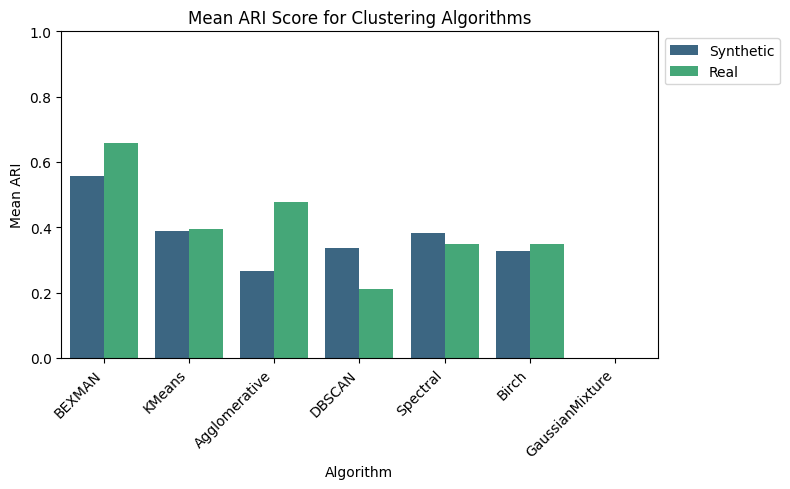

Aggregated mean ARI plot saved to: /content/aggregated_mean_ari_plot.png

🔹 **Neat Detailed ARI Results for Synthetic Datasets** 🔹
     Dataset  BEXMAN ARI  KMeans ARI  Agglomerative ARI  DBSCAN ARI  Spectral ARI  Birch ARI  GaussianMixture ARI
    compound    0.862162    0.455290           0.484127    0.740208      0.420908   0.733811                  0.0
      donut3    0.758065    0.773797           0.445701    0.570937      0.685263   0.512372                  0.0
spiralsquare    0.535311    0.338027           0.420569    0.000000      0.337409   0.498179                  0.0
      smile2    0.630420    0.479318           0.408788    1.000000      0.494807   0.463204                  0.0
      twenty    0.947774    0.491409           0.098285    0.000000      0.464057   0.172287                  0.0
       pearl    0.990130    0.250840           0.304143    0.000000      0.269248   0.753712                  0.0
          S1    0.911397    0.602621           0.131295    0.000000    

In [ ]:
import os
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, SpectralClustering, AgglomerativeClustering, OPTICS, MeanShift, Birch
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# # Dummy placeholder for RTC; replace with your actual implementation if available.
# class RT:
#     def __init__(self, n_kmeans_clusters=150, k=2, alpha=10.0, sparse_alpha=10, min_cluster_size=1, gamma=10, beta=-3, ratio_threshold=1):
#         self.n_kmeans_clusters = n_kmeans_clusters
#         self.k = k
#         self.alpha = alpha
#         self.sparse_alpha = sparse_alpha
#         self.min_cluster_size = min_cluster_size
#         self.gamma = gamma
#         self.beta = beta
#         self.ratio_threshold = ratio_threshold
#         self.final_labels = None
#
#     def fit_predict(self, X):
#         # For demonstration purposes, we use KMeans as a stand-in.
#         km = KMeans(n_clusters=self.k, random_state=42)
#         self.final_labels = km.fit_predict(X)
#         return self.final_labels

# Define dataset folder paths
real_data_folder = "/content/real_data"
synthetic_data_folder = "/content/synthetic_data"

# List of clustering algorithms (only ARI will be computed)
# For those algorithms that require a set number of clusters, you can adjust parameters as needed.
clustering_algorithms = {
    "BEXMAN": lambda X: RT(n_kmeans_clusters=150,
                          k=2,
                          alpha=10,
                          sparse_alpha=1,
                          min_cluster_size=1,
                          gamma=10,
                          beta=-3,
                          ratio_threshold=1,
                          random_state=42,
                          batch_size=None).fit_predict(X),
    "KMeans": lambda X: KMeans(random_state=42).fit_predict(X),
    "Agglomerative": lambda X: AgglomerativeClustering().fit_predict(X),
    "DBSCAN": lambda X: DBSCAN().fit_predict(X),
    "Spectral": lambda X: SpectralClustering(random_state=42, assign_labels="discretize").fit_predict(X),
    # "OPTICS": lambda X: OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05).fit_predict(X),
    # "MeanShift": lambda X: MeanShift().fit_predict(X),
    "Birch": lambda X: Birch().fit_predict(X),
    "GaussianMixture": lambda X: GaussianMixture(random_state=42).fit(X).predict(X)
}

def load_datasets(folder_path, file_extension):
    datasets = []
    if not os.path.exists(folder_path):
        print(f"Warning: Folder '{folder_path}' not found.")
        return datasets

    files = [f for f in os.listdir(folder_path) if f.endswith(file_extension)]
    if not files:
        print(f"Warning: No {file_extension} files found in '{folder_path}'.")
        return datasets

    for file in files:
        file_path = os.path.join(folder_path, file)
        dataset_name = os.path.splitext(file)[0]
        try:
            if file_extension == ".mat":
                data = scipy.io.loadmat(file_path)
                X, y = data.get("data"), data.get("label")
            elif file_extension == ".csv":
                df = pd.read_csv(file_path)
                X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values
            else:
                continue

            if X is None or y is None:
                print(f"Warning: 'data' or 'label' missing in '{file}'. Skipping.")
                continue

            X = StandardScaler().fit_transform(X)
            datasets.append({"name": dataset_name, "data": X, "ground_truth": y.flatten()})
            print(f"Loaded dataset: {dataset_name} from '{file}'")
        except Exception as e:
            print(f"Error loading '{file}': {e}. Skipping.")
    return datasets

def run_benchmark(datasets, dataset_type):
    """
    For each dataset, run all clustering algorithms and record only ARI.
    The result for each dataset is a dictionary with keys:
      - "Dataset" for the dataset name
      - For each algorithm, a key: {algo}_ARI.
    """
    results = []
    for dataset in datasets:
        dataset_name, X, y_true = dataset["name"], dataset["data"], dataset["ground_truth"]
        print(f"\nProcessing {dataset_type} dataset: {dataset_name}")

        dataset_results = {"Dataset": dataset_name}
        for algo_name, algo_func in clustering_algorithms.items():
            try:
                y_pred = algo_func(X)
                ari_score = adjusted_rand_score(y_true, y_pred)
                dataset_results[f"{algo_name}_ARI"] = ari_score
                print(f"  {algo_name}: ARI = {ari_score:.4f}")
            except Exception as e:
                print(f"  Error in {algo_name} for {dataset_name}: {e}")
                dataset_results[f"{algo_name}_ARI"] = None

        results.append(dataset_results)
    return results

# Load datasets
synthetic_datasets = load_datasets(synthetic_data_folder, ".mat")
real_mat_datasets = load_datasets(real_data_folder, ".mat")
real_csv_datasets = load_datasets(real_data_folder, ".csv")
real_datasets = real_mat_datasets + real_csv_datasets

# Run benchmarking for synthetic and real datasets
synthetic_results = run_benchmark(synthetic_datasets, "synthetic")
real_results = run_benchmark(real_datasets, "real")

# Convert results to DataFrame
df_synthetic = pd.DataFrame(synthetic_results)
df_real = pd.DataFrame(real_results)

# Save detailed results to CSV
synthetic_csv_path = "/content/synthetic_clustering_results.csv"
real_csv_path = "/content/real_clustering_results.csv"

df_synthetic.to_csv(synthetic_csv_path, index=False)
df_real.to_csv(real_csv_path, index=False)

print(f"\nSynthetic data results saved to: {synthetic_csv_path}")
print(f"Real data results saved to: {real_csv_path}")

# -------------------------
# Display Detailed Per-Dataset Results as Tables
# -------------------------
print("\n🔹 **Detailed ARI Results for Synthetic Datasets** 🔹")
print(df_synthetic)

print("\n🔹 **Detailed ARI Results for Real Datasets** 🔹")
print(df_real)

# -------------------------
# Aggregate Mean Scores for Compact Representation
# -------------------------
def aggregate_scores(df, dataset_type, metric_suffix="_ARI"):
    # Extract algorithm columns (excluding 'Dataset')
    algo_columns = [col for col in df.columns if col.endswith(metric_suffix)]

    # Compute aggregated mean scores
    mean_scores = df[algo_columns].mean().reset_index()
    mean_scores.columns = ["Algorithm", "Mean ARI"]

    # Remove the metric suffix from the algorithm names for clarity
    mean_scores["Algorithm"] = mean_scores["Algorithm"].str.replace(metric_suffix, "")

    # Add dataset type column
    mean_scores["Dataset Type"] = dataset_type

    return mean_scores

# Aggregate scores for synthetic and real datasets
synthetic_mean = aggregate_scores(df_synthetic, "Synthetic")
real_mean = aggregate_scores(df_real, "Real")

# Combine aggregated results
df_agg_mean = pd.concat([synthetic_mean, real_mean]).reset_index(drop=True)

# Save aggregated mean results to CSV
aggregated_mean_csv_path = "/content/aggregated_clustering_mean_results.csv"
df_agg_mean.to_csv(aggregated_mean_csv_path, index=False)

print(f"\nAggregated mean ARI results saved to: {aggregated_mean_csv_path}")

# Display aggregated DataFrame
print("\n🔹 **Aggregated Mean ARI Scores** 🔹")
print(df_agg_mean)

# -------------------------
# Visualization of Aggregated Results
# -------------------------
plt.figure(figsize=(8, 5))
sns.barplot(x="Algorithm", y="Mean ARI", hue="Dataset Type", data=df_agg_mean, palette="viridis")
plt.title("Mean ARI Score for Clustering Algorithms")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)  # ARI scores range from -1 to 1
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
mean_plot_path = "/content/aggregated_mean_ari_plot.png"
plt.savefig(mean_plot_path)
plt.show()
print(f"Aggregated mean ARI plot saved to: {mean_plot_path}")

# -------------------------
# Create Neat Detailed DataFrames for Each Dataset ARI Results
# -------------------------
# Create copies of the detailed results DataFrames for neat display
df_synthetic_neat = df_synthetic.copy()
df_real_neat = df_real.copy()

# Rename the ARI columns to remove underscores for a cleaner look
df_synthetic_neat.rename(columns=lambda x: x.replace("_ARI", " ARI"), inplace=True)
df_real_neat.rename(columns=lambda x: x.replace("_ARI", " ARI"), inplace=True)

print("\n🔹 **Neat Detailed ARI Results for Synthetic Datasets** 🔹")
print(df_synthetic_neat.to_string(index=False))

print("\n🔹 **Neat Detailed ARI Results for Real Datasets** 🔹")
print(df_real_neat.to_string(index=False))



--- Scenario: Uniform Noise ---
Candidate values per cluster: {np.int64(22): np.float64(2.1265470439411644), np.int64(27): np.float64(3.1842105263157894), np.int64(103): np.float64(3.399128473321452)}
Noise Detection Metrics (Precision, Recall, F1 Score):
DBSCAN -> Precision: 1.0000, Recall: 0.1600, F1: 0.2759
OPTICS -> Precision: 0.1695, Recall: 0.8000, F1: 0.2797
RT     -> Precision: 0.9474, Recall: 0.7200, F1: 0.8182


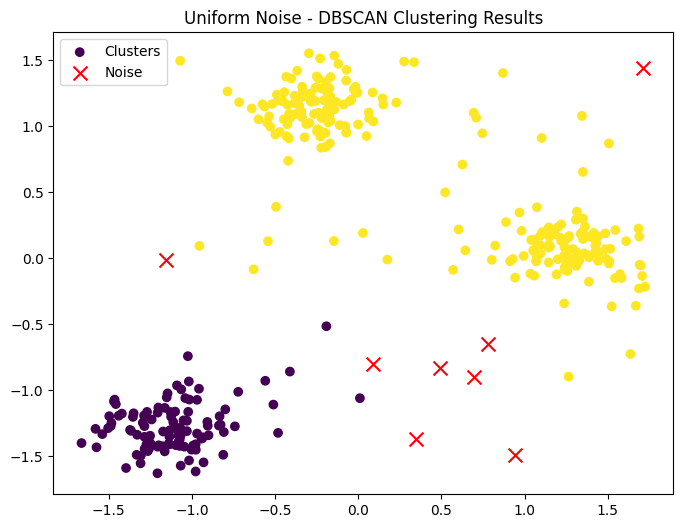


--- Scenario: Gaussian Noise ---
Candidate values per cluster: {np.int64(30): np.float64(3.2277464774419657), np.int64(82): np.float64(3.004936767193089)}
Noise Detection Metrics (Precision, Recall, F1 Score):
DBSCAN -> Precision: 1.0000, Recall: 0.0200, F1: 0.0392
OPTICS -> Precision: 0.1528, Recall: 0.7000, F1: 0.2509
RT     -> Precision: 0.9091, Recall: 0.8000, F1: 0.8511


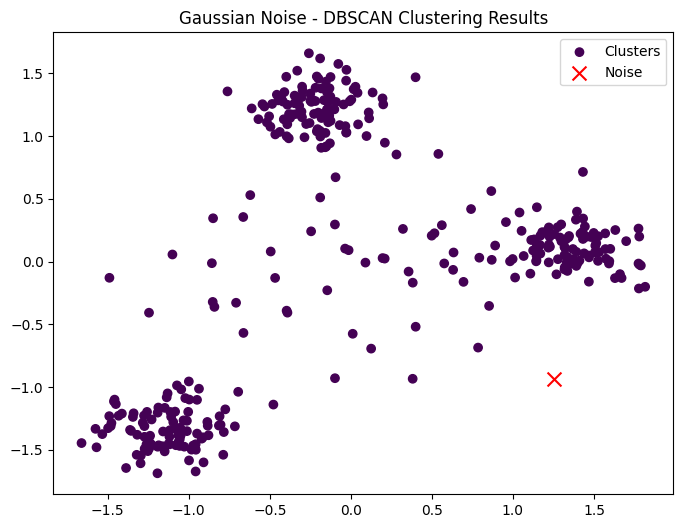


--- Scenario: Structured Noise ---
Candidate values per cluster: {np.int64(37): np.float64(1.3333333333333333), np.int64(65): np.float64(1.6343154471680754), np.int64(70): np.float64(2.2207967859187643), np.int64(101): np.float64(2.7811368519340913), np.int64(125): np.float64(2.7763598346914686)}
Noise Detection Metrics (Precision, Recall, F1 Score):
DBSCAN -> Precision: 0.0000, Recall: 0.0000, F1: 0.0000
OPTICS -> Precision: 0.1869, Recall: 0.8000, F1: 0.3030
RT     -> Precision: 0.1714, Recall: 0.1200, F1: 0.1412


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


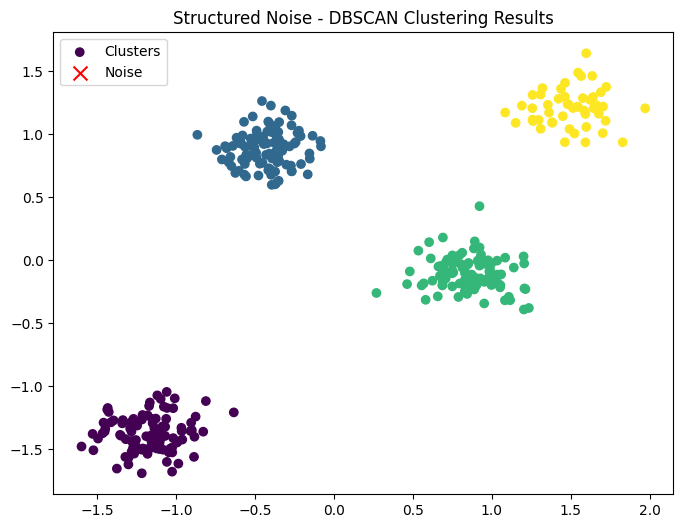


--- Scenario: Boundary Noise ---
Candidate values per cluster: {np.int64(9): np.float64(3.1666666666666665), np.int64(11): np.float64(2.165453443641859), np.int64(27): np.float64(2.5301910234928746), np.int64(63): np.float64(1.3200692741276663), np.int64(110): np.float64(3.1177758441590284)}
Noise Detection Metrics (Precision, Recall, F1 Score):
DBSCAN -> Precision: 0.0000, Recall: 0.0000, F1: 0.0000
OPTICS -> Precision: 0.1117, Recall: 0.4400, F1: 0.1781
RT     -> Precision: 0.3023, Recall: 0.2600, F1: 0.2796


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


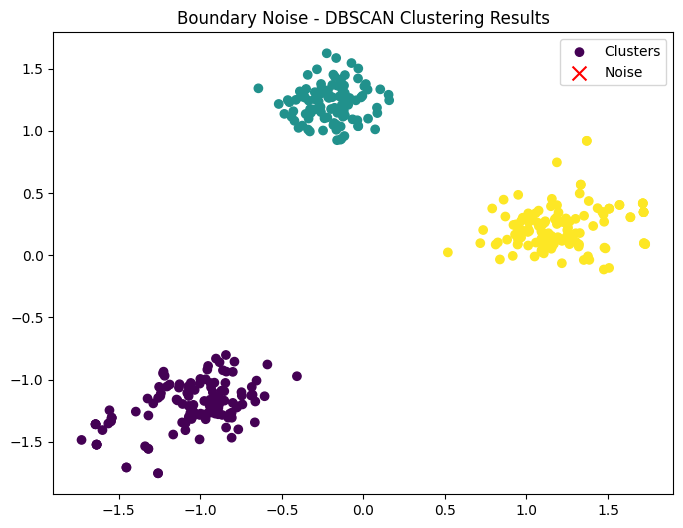


Summary of Noise Detection Metrics (Precision, Recall, F1):

Scenario: Uniform Noise
  DBSCAN: Precision=1.0000, Recall=0.1600, F1=0.2759
  OPTICS: Precision=0.1695, Recall=0.8000, F1=0.2797
  RT: Precision=0.9474, Recall=0.7200, F1=0.8182

Scenario: Gaussian Noise
  DBSCAN: Precision=1.0000, Recall=0.0200, F1=0.0392
  OPTICS: Precision=0.1528, Recall=0.7000, F1=0.2509
  RT: Precision=0.9091, Recall=0.8000, F1=0.8511

Scenario: Structured Noise
  DBSCAN: Precision=0.0000, Recall=0.0000, F1=0.0000
  OPTICS: Precision=0.1869, Recall=0.8000, F1=0.3030
  RT: Precision=0.1714, Recall=0.1200, F1=0.1412

Scenario: Boundary Noise
  DBSCAN: Precision=0.0000, Recall=0.0000, F1=0.0000
  OPTICS: Precision=0.1117, Recall=0.4400, F1=0.1781
  RT: Precision=0.3023, Recall=0.2600, F1=0.2796


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Helper Functions
# -------------------------------
def generate_base_data(n_samples=300, centers=3, cluster_std=1.0, random_state=42):
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=random_state)
    return X, y

def add_uniform_noise(X, y, n_noise=50):
    # Create uniform noise within the min and max of each feature dimension
    noise = np.random.uniform(low=X.min(axis=0), high=X.max(axis=0), size=(n_noise, X.shape[1]))
    X_noise = np.vstack([X, noise])
    y_noise = np.hstack([y, [-1] * n_noise])
    return X_noise, y_noise

def add_gaussian_noise(X, y, n_noise=50, noise_std=3.0):
    # Create Gaussian noise centered at the overall mean
    mean = X.mean(axis=0)
    noise = np.random.normal(loc=mean, scale=noise_std, size=(n_noise, X.shape[1]))
    X_noise = np.vstack([X, noise])
    y_noise = np.hstack([y, [-1] * n_noise])
    return X_noise, y_noise

def add_structured_noise(X, y, n_noise=50, offset=10):
    # Create a separate cluster of noise far away from the main clusters
    noise_center = X.mean(axis=0) + offset
    noise = np.random.normal(loc=noise_center, scale=1.0, size=(n_noise, X.shape[1]))
    X_noise = np.vstack([X, noise])
    y_noise = np.hstack([y, [-1] * n_noise])
    return X_noise, y_noise

def add_boundary_noise(X, y, n_noise=50, noise_factor=1.2):
    """
    Create boundary noise by identifying points that lie on the edges of clusters.
    Here, we use KMeans on the base data to find clusters. Then, we compute the
    distance of each point to its cluster center and select points in the top 10%
    (i.e. near the boundary). A noise factor is applied to slightly push these
    points outward.
    """
    # Use KMeans to determine cluster centers for the base data (ignoring noise labels)
    unique_labels = np.unique(y)
    km = KMeans(n_clusters=len(unique_labels), random_state=42).fit(X)
    centers = km.cluster_centers_
    # Assign each base point to a cluster (using the provided labels as an index)
    distances = np.linalg.norm(X - centers[y], axis=1)
    # Select points that lie near the boundary (e.g., top 10% distances)
    threshold = np.percentile(distances, 90)
    boundary_points = X[distances >= threshold]
    # If not enough boundary points, fall back to a random selection from X
    if len(boundary_points) < 1:
        boundary_points = X
    indices = np.random.choice(len(boundary_points), size=n_noise, replace=True)
    noise = boundary_points[indices] * noise_factor
    X_noise = np.vstack([X, noise])
    y_noise = np.hstack([y, [-1] * n_noise])
    return X_noise, y_noise

def evaluate_noise_detection(y_true, y_pred):
    """
    Convert labels into binary noise indicators:
      1 for noise (i.e. label == -1)
      0 for inlier.
    Then compute precision, recall, and F1 score.
    """
    y_true_noise = (np.array(y_true) == -1).astype(int)
    y_pred_noise = (np.array(y_pred) == -1).astype(int)
    precision = precision_score(y_true_noise, y_pred_noise)
    recall = recall_score(y_true_noise, y_pred_noise)
    f1 = f1_score(y_true_noise, y_pred_noise)
    return precision, recall, f1

def plot_clusters(X, labels, title):
    plt.figure(figsize=(8, 6))
    inlier_mask = labels != -1
    noise_mask = labels == -1
    plt.scatter(X[inlier_mask, 0], X[inlier_mask, 1], c=labels[inlier_mask], cmap='viridis', label='Clusters')
    plt.scatter(X[noise_mask, 0], X[noise_mask, 1], c='red', marker='x', s=100, label='Noise')
    plt.title(title)
    plt.legend()
    plt.show()

# -------------------------------
# Dummy RT Algorithm (for demonstration)
# -------------------------------
# This dummy RT algorithm uses KMeans to assign clusters, then marks points as noise
# if their distance from the cluster center exceeds a threshold.
# You can adjust its parameters as needed.
# class RT:
#     def __init__(self, n_kmeans_clusters=150, k=2, alpha=10, sparse_alpha=1, min_cluster_size=1,
#                  gamma=2, beta=-3, ratio_threshold=0.8, random_state=42, batch_size=None):
#         self.n_kmeans_clusters = n_kmeans_clusters
#         self.k = k
#         self.alpha = alpha
#         self.sparse_alpha = sparse_alpha
#         self.min_cluster_size = min_cluster_size
#         self.gamma = gamma
#         self.beta = beta
#         self.ratio_threshold = ratio_threshold
#         self.random_state = random_state
#         self.batch_size = batch_size

#     def fit_predict(self, X):
#         # Using KMeans to over-segment the space
#         km = KMeans(n_clusters=self.n_kmeans_clusters, random_state=self.random_state)
#         labels = km.fit_predict(X)
#         centers = km.cluster_centers_
#         # Compute Euclidean distances from each point to its assigned cluster center
#         distances = np.linalg.norm(X - centers[labels], axis=1)
#         std_dist = np.std(distances)
#         # Mark points as noise if they exceed a threshold
#         noise = distances > (self.alpha * std_dist)
#         labels[noise] = -1
#         return labels

# -------------------------------
# Clustering Algorithms for Comparison
# -------------------------------
def run_clustering_algorithms(X):
    dbscan_labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(X)
    optics_labels = OPTICS(min_samples=5).fit_predict(X)
    rt_labels = RT(n_kmeans_clusters=150,
                   k=2,
                   alpha=10,
                   sparse_alpha=1,
                   min_cluster_size=1,
                   gamma=2,
                   beta=-3,
                   ratio_threshold=0.8,
                   random_state=42,
                   batch_size=None).fit_predict(X)
    return dbscan_labels, optics_labels, rt_labels

# -------------------------------
# Main Workflow for Different Noise Scenarios
# -------------------------------
def compare_noise_scenarios():
    # Generate base blob data
    X_base, y_base = generate_base_data(n_samples=300, centers=3, cluster_std=1.0, random_state=42)

    # Dictionary to hold different noise scenarios.
    # Increase n_noise to add more noise points.
    scenarios = {
        "Uniform Noise": add_uniform_noise,
        "Gaussian Noise": add_gaussian_noise,
        "Structured Noise": add_structured_noise,
        "Boundary Noise": add_boundary_noise
    }

    results = {}

    for scenario_name, noise_func in scenarios.items():
        print(f"\n--- Scenario: {scenario_name} ---")
        # Generate dataset with increased noise
        X_noise, y_noise = noise_func(X_base, y_base, n_noise=50)

        # Standardize data
        scaler = StandardScaler()
        X_noise = scaler.fit_transform(X_noise)

        # Run clustering algorithms
        dbscan_labels, optics_labels, rt_labels = run_clustering_algorithms(X_noise)

        # Evaluate noise detection metrics
        dbscan_metrics = evaluate_noise_detection(y_noise, dbscan_labels)
        optics_metrics = evaluate_noise_detection(y_noise, optics_labels)
        rt_metrics = evaluate_noise_detection(y_noise, rt_labels)

        # Store metrics for later comparison
        results[scenario_name] = {
            "DBSCAN": dbscan_metrics,
            "OPTICS": optics_metrics,
            "RT": rt_metrics
        }

        # Print metrics
        print("Noise Detection Metrics (Precision, Recall, F1 Score):")
        print("DBSCAN -> Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*dbscan_metrics))
        print("OPTICS -> Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*optics_metrics))
        print("RT     -> Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*rt_metrics))

        # Visualize clustering result for one algorithm as an example
        plot_clusters(X_noise, dbscan_labels, f"{scenario_name} - DBSCAN Clustering Results")

    return results

# Run the comparison
noise_comparison_results = compare_noise_scenarios()

# Optionally, print the collected results for all scenarios
print("\nSummary of Noise Detection Metrics (Precision, Recall, F1):")
for scenario, metrics in noise_comparison_results.items():
    print(f"\nScenario: {scenario}")
    for algo, metric in metrics.items():
        print(f"  {algo}: Precision={metric[0]:.4f}, Recall={metric[1]:.4f}, F1={metric[2]:.4f}")



=== Base Data with 3 Clusters ===

--- Noise Scenario: Uniform Noise ---
Candidate values per cluster: {np.int64(22): np.float64(2.1265470439411644), np.int64(27): np.float64(3.1842105263157894), np.int64(103): np.float64(3.399128473321452)}
Noise Detection Metrics (Precision, Recall, F1 Score):
DBSCAN -> Precision: 1.0000, Recall: 0.1600, F1: 0.2759
OPTICS -> Precision: 0.1695, Recall: 0.8000, F1: 0.2797
RT     -> Precision: 0.9474, Recall: 0.7200, F1: 0.8182


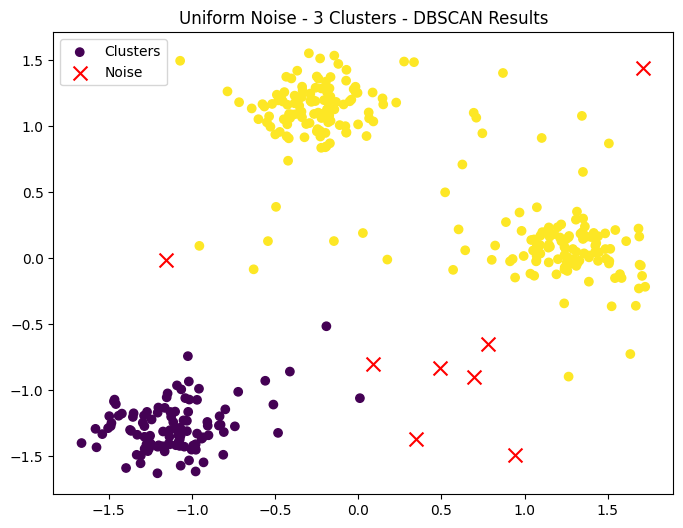


--- Noise Scenario: Gaussian Noise ---
Candidate values per cluster: {np.int64(30): np.float64(3.2277464774419657), np.int64(82): np.float64(3.004936767193089)}
Noise Detection Metrics (Precision, Recall, F1 Score):
DBSCAN -> Precision: 1.0000, Recall: 0.0200, F1: 0.0392
OPTICS -> Precision: 0.1528, Recall: 0.7000, F1: 0.2509
RT     -> Precision: 0.9091, Recall: 0.8000, F1: 0.8511


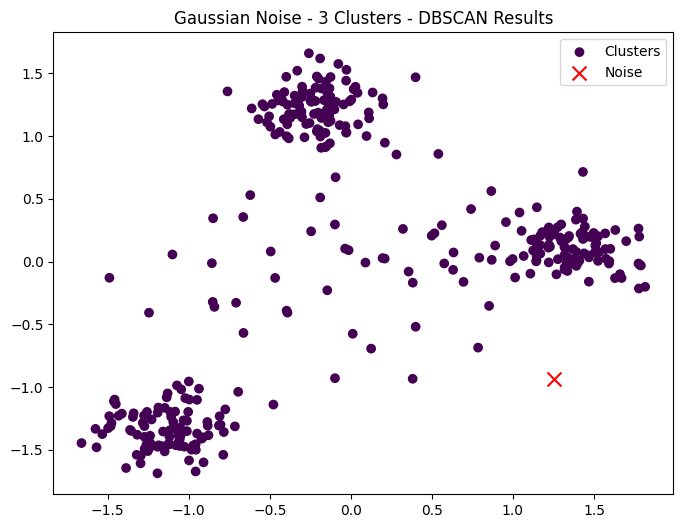


--- Noise Scenario: Structured Noise ---
Candidate values per cluster: {np.int64(37): np.float64(1.3333333333333333), np.int64(65): np.float64(1.6343154471680754), np.int64(70): np.float64(2.2207967859187643), np.int64(101): np.float64(2.7811368519340913), np.int64(125): np.float64(2.7763598346914686)}
Noise Detection Metrics (Precision, Recall, F1 Score):
DBSCAN -> Precision: 0.0000, Recall: 0.0000, F1: 0.0000
OPTICS -> Precision: 0.1869, Recall: 0.8000, F1: 0.3030
RT     -> Precision: 0.1714, Recall: 0.1200, F1: 0.1412


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


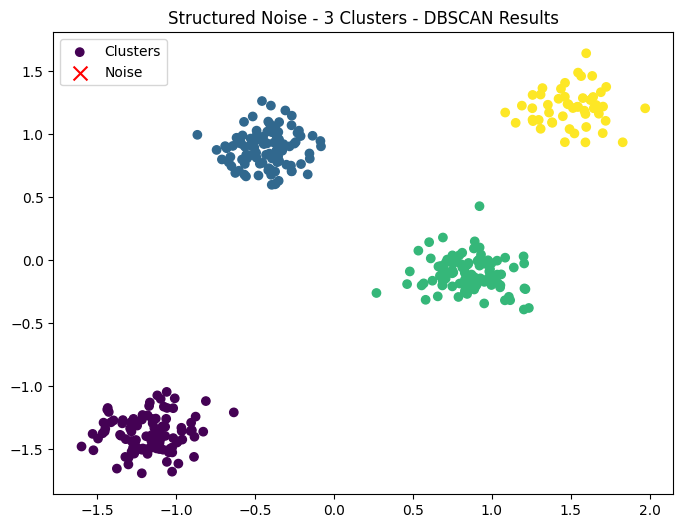


--- Noise Scenario: Boundary Noise ---
Candidate values per cluster: {np.int64(9): np.float64(3.1666666666666665), np.int64(11): np.float64(2.165453443641859), np.int64(27): np.float64(2.5301910234928746), np.int64(63): np.float64(1.3200692741276663), np.int64(110): np.float64(3.1177758441590284)}
Noise Detection Metrics (Precision, Recall, F1 Score):
DBSCAN -> Precision: 0.0000, Recall: 0.0000, F1: 0.0000
OPTICS -> Precision: 0.1117, Recall: 0.4400, F1: 0.1781
RT     -> Precision: 0.3023, Recall: 0.2600, F1: 0.2796


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


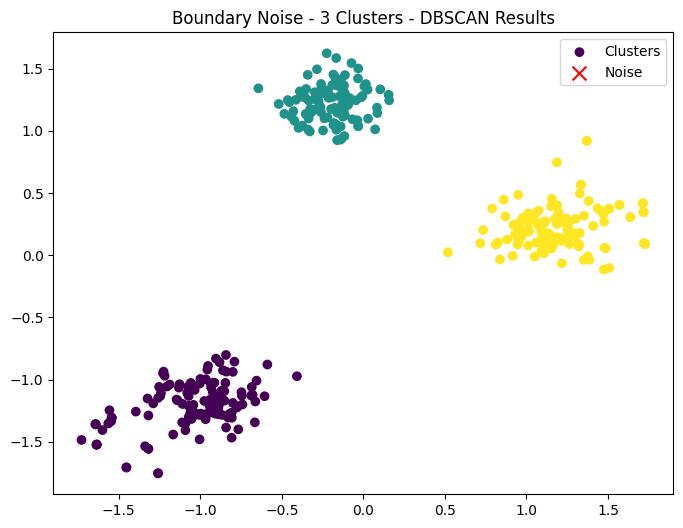


=== Base Data with 5 Clusters ===

--- Noise Scenario: Uniform Noise ---
Candidate values per cluster: {np.int64(69): np.float64(1.2496139862649955), np.int64(81): np.float64(4.378744554074006), np.int64(85): np.float64(3.5434913492322564), np.int64(120): np.float64(3.054165076443869)}
Noise Detection Metrics (Precision, Recall, F1 Score):
DBSCAN -> Precision: 1.0000, Recall: 0.1800, F1: 0.3051
OPTICS -> Precision: 0.2390, Recall: 0.9800, F1: 0.3843
RT     -> Precision: 0.9333, Recall: 0.5600, F1: 0.7000


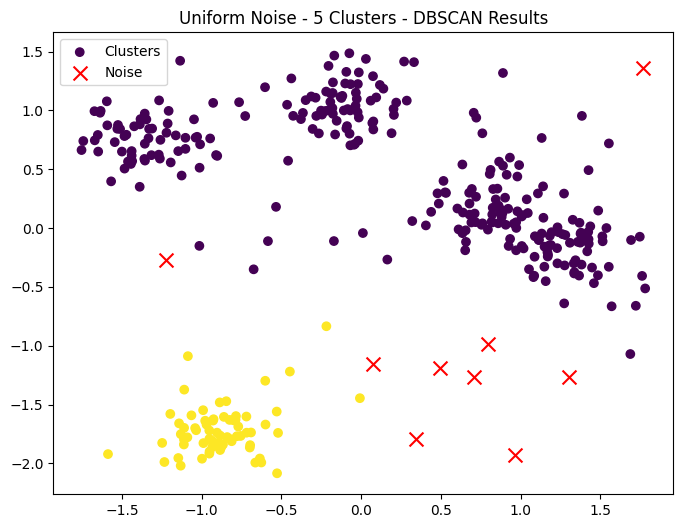


--- Noise Scenario: Gaussian Noise ---
Candidate values per cluster: {np.int64(72): np.float64(3.7564765553610995), np.int64(86): np.float64(1.7734201905959515), np.int64(101): np.float64(2.4575069242253598), np.int64(104): np.float64(3.101261626330636)}
Noise Detection Metrics (Precision, Recall, F1 Score):
DBSCAN -> Precision: 1.0000, Recall: 0.0200, F1: 0.0392
OPTICS -> Precision: 0.1929, Recall: 0.7600, F1: 0.3077
RT     -> Precision: 0.7500, Recall: 0.4800, F1: 0.5854


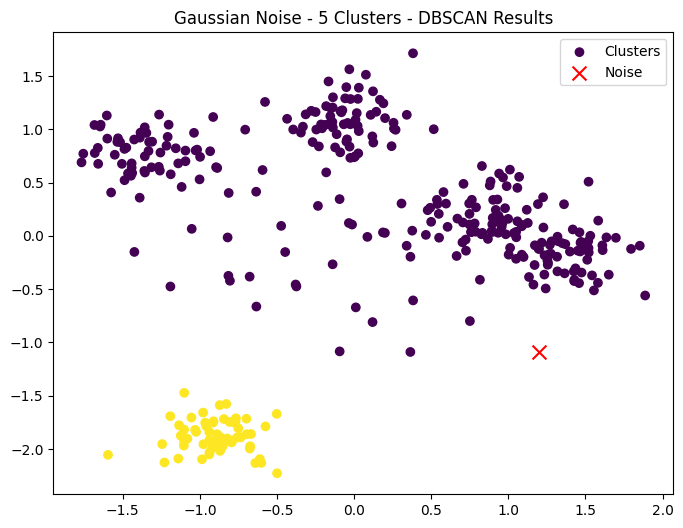


--- Noise Scenario: Structured Noise ---
Candidate values per cluster: {np.int64(4): np.float64(2.924368012269446), np.int64(22): np.float64(2.037933831783678), np.int64(51): np.float64(3.0826014185484585), np.int64(82): np.float64(1.980741188675624), np.int64(85): np.float64(2.7297340180010536), np.int64(103): np.float64(3.074577350606792)}
Noise Detection Metrics (Precision, Recall, F1 Score):
DBSCAN -> Precision: 0.0000, Recall: 0.0000, F1: 0.0000
OPTICS -> Precision: 0.2167, Recall: 0.8800, F1: 0.3478
RT     -> Precision: 0.1471, Recall: 0.1000, F1: 0.1190


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


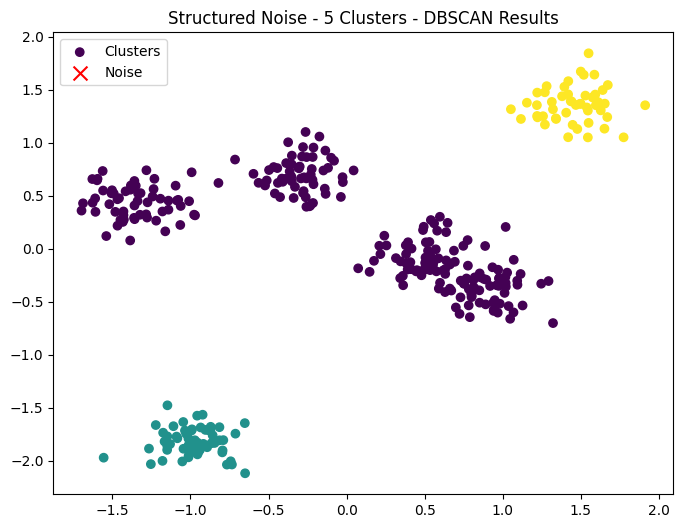


--- Noise Scenario: Boundary Noise ---
Candidate values per cluster: {np.int64(5): np.float64(2.652220238179883), np.int64(6): np.float64(3.0774089205572808), np.int64(15): np.float64(1.0804949602465914), np.int64(26): np.float64(2.2674734615075494), np.int64(51): np.float64(4.921367548465182), np.int64(62): np.float64(4.125), np.int64(108): np.float64(2.7353166686691543)}
Noise Detection Metrics (Precision, Recall, F1 Score):
DBSCAN -> Precision: 0.0000, Recall: 0.0000, F1: 0.0000
OPTICS -> Precision: 0.0773, Recall: 0.2800, F1: 0.1212
RT     -> Precision: 0.2750, Recall: 0.2200, F1: 0.2444


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


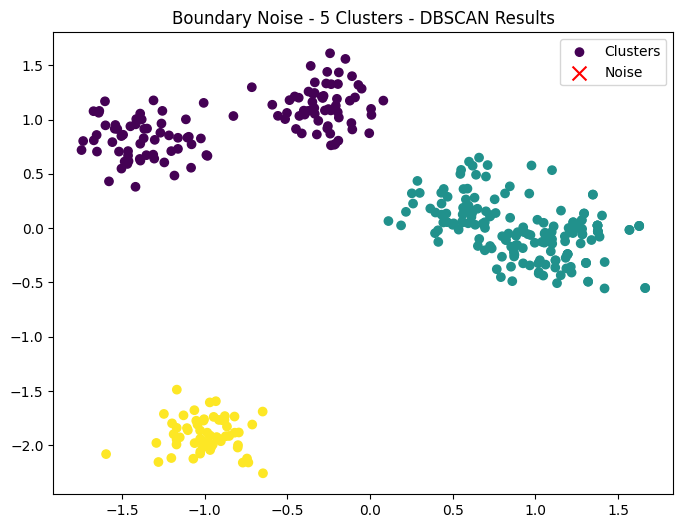


=== Base Data with 7 Clusters ===

--- Noise Scenario: Uniform Noise ---
Candidate values per cluster: {np.int64(73): np.float64(4.588717180662707), np.int64(78): np.float64(3.173183161323693), np.int64(100): np.float64(5.554301422468624), np.int64(108): np.float64(3.0), np.int64(117): np.float64(2.5636250614298977)}
Noise Detection Metrics (Precision, Recall, F1 Score):
DBSCAN -> Precision: 1.0000, Recall: 0.0400, F1: 0.0769
OPTICS -> Precision: 0.2258, Recall: 0.9800, F1: 0.3670
RT     -> Precision: 0.8205, Recall: 0.6400, F1: 0.7191


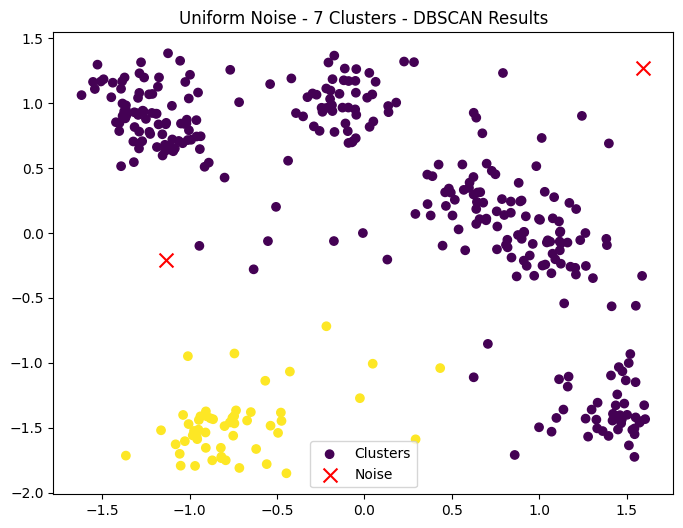


--- Noise Scenario: Gaussian Noise ---
Candidate values per cluster: {np.int64(14): np.float64(2.484935051320401), np.int64(25): np.float64(3.2171754189387145), np.int64(34): np.float64(1.5424329278429698), np.int64(38): np.float64(4.172608348057064), np.int64(51): np.float64(2.5485954256218766), np.int64(88): np.float64(3.4558187400800744)}
Noise Detection Metrics (Precision, Recall, F1 Score):
DBSCAN -> Precision: 0.0000, Recall: 0.0000, F1: 0.0000
OPTICS -> Precision: 0.2010, Recall: 0.8000, F1: 0.3213
RT     -> Precision: 0.6500, Recall: 0.5200, F1: 0.5778


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


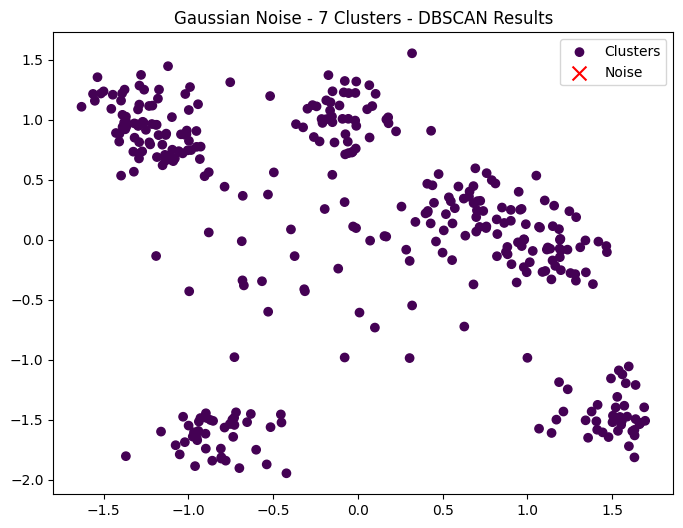


--- Noise Scenario: Structured Noise ---
Candidate values per cluster: {np.int64(1): np.float64(3.6789914706334788), np.int64(18): np.float64(1.0533719328035531), np.int64(21): np.float64(3.730023908118884), np.int64(38): np.float64(2.8852891441202835), np.int64(44): np.float64(2.0744986991381604), np.int64(48): np.float64(2.0833294776775464), np.int64(99): np.float64(2.0839185557136513), np.int64(121): np.float64(3.249006546580042), np.int64(126): np.float64(2.53125)}
Noise Detection Metrics (Precision, Recall, F1 Score):
DBSCAN -> Precision: 0.0000, Recall: 0.0000, F1: 0.0000
OPTICS -> Precision: 0.1878, Recall: 0.7400, F1: 0.2996
RT     -> Precision: 0.1351, Recall: 0.1000, F1: 0.1149


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


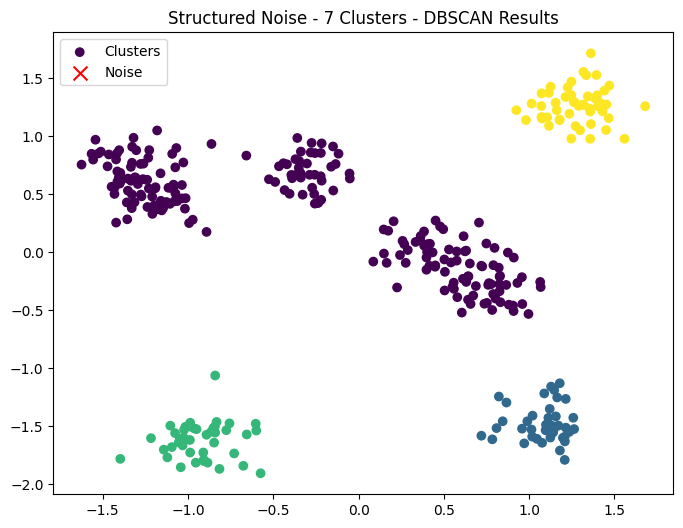


--- Noise Scenario: Boundary Noise ---
Candidate values per cluster: {np.int64(5): np.float64(1.364234804171533), np.int64(7): np.float64(2.7352354988716803), np.int64(27): np.float64(2.5555555555555554), np.int64(78): np.float64(2.3277598203216767), np.int64(100): np.float64(2.4523877453235956), np.int64(101): np.float64(2.446684692336289), np.int64(125): np.float64(5.130754647780778)}
Noise Detection Metrics (Precision, Recall, F1 Score):
DBSCAN -> Precision: 0.0000, Recall: 0.0000, F1: 0.0000
OPTICS -> Precision: 0.0710, Recall: 0.2400, F1: 0.1096
RT     -> Precision: 0.1290, Recall: 0.0800, F1: 0.0988


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


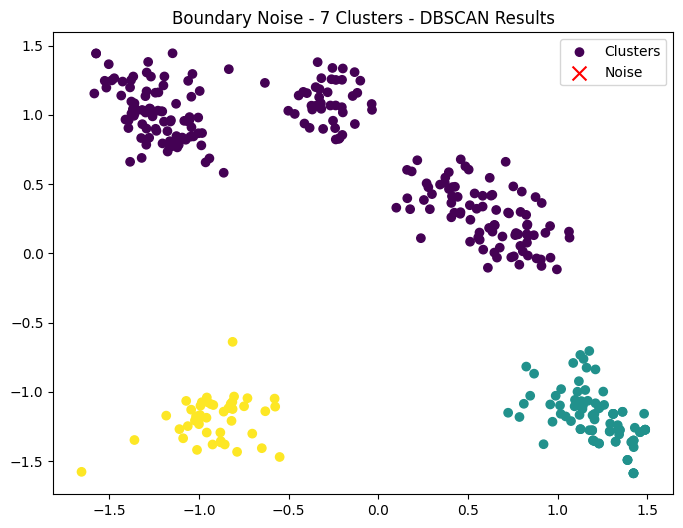


Summary of Noise Detection Metrics (Precision, Recall, F1):

Base Data with 3 Clusters:
  Uniform Noise:
    DBSCAN: Precision=1.0000, Recall=0.1600, F1=0.2759
    OPTICS: Precision=0.1695, Recall=0.8000, F1=0.2797
    RT: Precision=0.9474, Recall=0.7200, F1=0.8182
  Gaussian Noise:
    DBSCAN: Precision=1.0000, Recall=0.0200, F1=0.0392
    OPTICS: Precision=0.1528, Recall=0.7000, F1=0.2509
    RT: Precision=0.9091, Recall=0.8000, F1=0.8511
  Structured Noise:
    DBSCAN: Precision=0.0000, Recall=0.0000, F1=0.0000
    OPTICS: Precision=0.1869, Recall=0.8000, F1=0.3030
    RT: Precision=0.1714, Recall=0.1200, F1=0.1412
  Boundary Noise:
    DBSCAN: Precision=0.0000, Recall=0.0000, F1=0.0000
    OPTICS: Precision=0.1117, Recall=0.4400, F1=0.1781
    RT: Precision=0.3023, Recall=0.2600, F1=0.2796

Base Data with 5 Clusters:
  Uniform Noise:
    DBSCAN: Precision=1.0000, Recall=0.1800, F1=0.3051
    OPTICS: Precision=0.2390, Recall=0.9800, F1=0.3843
    RT: Precision=0.9333, Recall=0.5600

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Helper Functions
# -------------------------------
def generate_base_data(n_samples=300, centers=3, cluster_std=1.0, random_state=42):
    """
    Generate base clustered data using make_blobs.
    """
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=random_state)
    return X, y

def add_uniform_noise(X, y, n_noise=50):
    """
    Add uniform noise within the range of the dataset.
    """
    noise = np.random.uniform(low=X.min(axis=0), high=X.max(axis=0), size=(n_noise, X.shape[1]))
    X_noise = np.vstack([X, noise])
    y_noise = np.hstack([y, [-1] * n_noise])
    return X_noise, y_noise

def add_gaussian_noise(X, y, n_noise=50, noise_std=3.0):
    """
    Add Gaussian noise centered on the overall mean of the dataset.
    """
    mean = X.mean(axis=0)
    noise = np.random.normal(loc=mean, scale=noise_std, size=(n_noise, X.shape[1]))
    X_noise = np.vstack([X, noise])
    y_noise = np.hstack([y, [-1] * n_noise])
    return X_noise, y_noise

def add_structured_noise(X, y, n_noise=50, offset=10):
    """
    Add structured noise by creating a separate cluster of noise far away from the main clusters.
    """
    noise_center = X.mean(axis=0) + offset
    noise = np.random.normal(loc=noise_center, scale=1.0, size=(n_noise, X.shape[1]))
    X_noise = np.vstack([X, noise])
    y_noise = np.hstack([y, [-1] * n_noise])
    return X_noise, y_noise

def add_boundary_noise(X, y, n_noise=50, noise_factor=1.2):
    """
    Create boundary noise by identifying points that lie near the edges of clusters.
    This is done by first running KMeans to determine the cluster centers,
    then selecting points whose distance to their cluster center is in the top 10%,
    and finally perturbing these points outward.
    """
    unique_labels = np.unique(y)
    km = KMeans(n_clusters=len(unique_labels), random_state=42).fit(X)
    centers = km.cluster_centers_
    distances = np.linalg.norm(X - centers[y], axis=1)
    threshold = np.percentile(distances, 90)
    boundary_points = X[distances >= threshold]
    # If there are fewer boundary points than required, sample with replacement
    indices = np.random.choice(len(boundary_points), size=n_noise, replace=True)
    noise = boundary_points[indices] * noise_factor
    X_noise = np.vstack([X, noise])
    y_noise = np.hstack([y, [-1] * n_noise])
    return X_noise, y_noise

def evaluate_noise_detection(y_true, y_pred):
    """
    Evaluate noise detection by converting labels into binary indicators:
      1 for noise (label == -1) and 0 for inliers.
    Computes precision, recall, and F1 score.
    """
    y_true_noise = (np.array(y_true) == -1).astype(int)
    y_pred_noise = (np.array(y_pred) == -1).astype(int)
    precision = precision_score(y_true_noise, y_pred_noise)
    recall = recall_score(y_true_noise, y_pred_noise)
    f1 = f1_score(y_true_noise, y_pred_noise)
    return precision, recall, f1

def plot_clusters(X, labels, title):
    """
    Plot clustering results. Noise points (labeled -1) are marked in red.
    """
    plt.figure(figsize=(8, 6))
    inlier_mask = labels != -1
    noise_mask = labels == -1
    plt.scatter(X[inlier_mask, 0], X[inlier_mask, 1], c=labels[inlier_mask], cmap='viridis', label='Clusters')
    plt.scatter(X[noise_mask, 0], X[noise_mask, 1], c='red', marker='x', s=100, label='Noise')
    plt.title(title)
    plt.legend()
    plt.show()

# -------------------------------
# Dummy RT Algorithm (for demonstration)
# -------------------------------
# class RT:
#     def __init__(self, n_kmeans_clusters=150, k=2, alpha=10, sparse_alpha=1, min_cluster_size=1,
#                  gamma=2, beta=-3, ratio_threshold=0.8, random_state=42, batch_size=None):
#         self.n_kmeans_clusters = n_kmeans_clusters
#         self.k = k
#         self.alpha = alpha
#         self.sparse_alpha = sparse_alpha
#         self.min_cluster_size = min_cluster_size
#         self.gamma = gamma
#         self.beta = beta
#         self.ratio_threshold = ratio_threshold
#         self.random_state = random_state
#         self.batch_size = batch_size

#     def fit_predict(self, X):
#         # Over-segment using KMeans and then mark points as noise if far from cluster centers.
#         km = KMeans(n_clusters=self.n_kmeans_clusters, random_state=self.random_state)
#         labels = km.fit_predict(X)
#         centers = km.cluster_centers_
#         distances = np.linalg.norm(X - centers[labels], axis=1)
#         std_dist = np.std(distances)
#         noise = distances > (self.alpha * std_dist)
#         labels[noise] = -1
#         return labels

# -------------------------------
# Clustering Algorithms for Comparison
# -------------------------------
def run_clustering_algorithms(X):
    dbscan_labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(X)
    optics_labels = OPTICS(min_samples=5).fit_predict(X)
    rt_labels = RT(n_kmeans_clusters=150,
                   k=2,
                   alpha=10,
                   sparse_alpha=1,
                   min_cluster_size=1,
                   gamma=2,
                   beta=-3,
                   ratio_threshold=0.8,
                   random_state=42,
                   batch_size=None).fit_predict(X)
    return dbscan_labels, optics_labels, rt_labels

# -------------------------------
# Main Workflow for Different Noise Scenarios & Cluster Configurations
# -------------------------------
def compare_noise_and_cluster_scenarios():
    # Define the different numbers of clusters to test.
    cluster_configs = [3, 5, 7]

    # Dictionary to hold the results
    results = {}

    # Define noise scenarios
    noise_scenarios = {
        "Uniform Noise": add_uniform_noise,
        "Gaussian Noise": add_gaussian_noise,
        "Structured Noise": add_structured_noise,
        "Boundary Noise": add_boundary_noise
    }

    # Loop over each cluster configuration
    for n_clusters in cluster_configs:
        print(f"\n=== Base Data with {n_clusters} Clusters ===")
        # Generate base data with a specified number of clusters
        X_base, y_base = generate_base_data(n_samples=300, centers=n_clusters, cluster_std=1.0, random_state=42)

        # Dictionary to store results for the current cluster configuration
        results[n_clusters] = {}

        # Loop over each noise scenario
        for scenario_name, noise_func in noise_scenarios.items():
            print(f"\n--- Noise Scenario: {scenario_name} ---")
            # Add noise (with increased noise points)
            X_noise, y_noise = noise_func(X_base, y_base, n_noise=50)

            # Standardize the data
            scaler = StandardScaler()
            X_noise = scaler.fit_transform(X_noise)

            # Run clustering algorithms
            dbscan_labels, optics_labels, rt_labels = run_clustering_algorithms(X_noise)

            # Evaluate noise detection metrics
            dbscan_metrics = evaluate_noise_detection(y_noise, dbscan_labels)
            optics_metrics = evaluate_noise_detection(y_noise, optics_labels)
            rt_metrics = evaluate_noise_detection(y_noise, rt_labels)

            # Store metrics for this noise scenario
            results[n_clusters][scenario_name] = {
                "DBSCAN": dbscan_metrics,
                "OPTICS": optics_metrics,
                "RT": rt_metrics
            }

            # Print metrics
            print("Noise Detection Metrics (Precision, Recall, F1 Score):")
            print("DBSCAN -> Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*dbscan_metrics))
            print("OPTICS -> Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*optics_metrics))
            print("RT     -> Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*rt_metrics))

            # Visualize clustering result for one algorithm (using DBSCAN as an example)
            plot_clusters(X_noise, dbscan_labels, f"{scenario_name} - {n_clusters} Clusters - DBSCAN Results")

    return results

# Run the comparison across different cluster configurations and noise scenarios
comparison_results = compare_noise_and_cluster_scenarios()

# Optionally, print a summary of all results
print("\nSummary of Noise Detection Metrics (Precision, Recall, F1):")
for n_clusters, scenarios in comparison_results.items():
    print(f"\nBase Data with {n_clusters} Clusters:")
    for scenario, metrics in scenarios.items():
        print(f"  {scenario}:")
        for algo, metric in metrics.items():
            print(f"    {algo}: Precision={metric[0]:.4f}, Recall={metric[1]:.4f}, F1={metric[2]:.4f}")



🔹 Running scalability test for 2 dimensions...
Candidate values per cluster: {np.int64(123): np.float64(32.01179550659509), np.int64(142): np.float64(33.87404077237734)}
  ✅ BEXMAN: ARI = 0.2104, Time = 0.52s
  ✅ KMeans: ARI = 0.6133, Time = 0.00s
  ✅ Agglomerative: ARI = 0.6137, Time = 0.93s
  ✅ DBSCAN: ARI = 0.2104, Time = 0.12s
  ✅ Spectral: ARI = 0.6137, Time = 4.59s
  ✅ Birch: ARI = 0.6125, Time = 0.05s
  ✅ GaussianMixture: ARI = 0.6133, Time = 0.02s

🔹 Running scalability test for 3 dimensions...
Candidate values per cluster: {np.int64(127): np.float64(31.1875), np.int64(131): np.float64(35.05660381340801), np.int64(134): np.float64(37.5471112847363), np.int64(141): np.float64(30.759150118339324), np.int64(149): np.float64(33.99243953059174)}
  ✅ BEXMAN: ARI = 0.9878, Time = 0.59s
  ✅ KMeans: ARI = 0.6152, Time = 0.00s
  ✅ Agglomerative: ARI = 0.6152, Time = 0.97s
  ✅ DBSCAN: ARI = 0.6152, Time = 0.16s
  ✅ Spectral: ARI = 0.6152, Time = 6.08s
  ✅ Birch: ARI = 0.6152, Time = 0.05

,Dimensions,BEXMAN,BEXMAN_Time,KMeans,KMeans_Time,Agglomerative,Agglomerative_Time,DBSCAN,DBSCAN_Time,Spectral,Spectral_Time,Birch,Birch_Time,GaussianMixture,GaussianMixture_Time
0,2,0.210393,0.515634,0.613276,0.004793,0.613659,0.929308,0.210393,0.122563,0.613659,4.588542,0.612513,0.052975,0.613277,0.016080
1,3,0.987835,0.587742,0.615195,0.004313,0.615195,0.974791,0.615195,0.161953,0.615195,6.081374,0.615195,0.053646,0.615195,0.016460
2,5,1.000000,0.625950,0.482559,0.004065,0.482559,1.090458,0.999500,0.164952,0.482559,4.790166,0.482559,0.097944,0.482559,0.031206
3,10,1.000000,1.372733,0.482559,0.010105,0.615195,1.319719,0.762402,0.195211,0.615195,5.151427,0.482559,0.157649,0.482559,0.024878
4,15,1.000000,1.108788,0.482559,0.007388,0.482559,1.174235,0.065401,0.322307,0.482559,6.600801,0.482559,0.227612,0.482559,0.182253
5,20,1.000000,1.221527,0.615195,0.008968,0.615195,1.178908,0.000000,0.095207,0.482559,8.024219,0.615195,0.613597,0.615195,0.283962


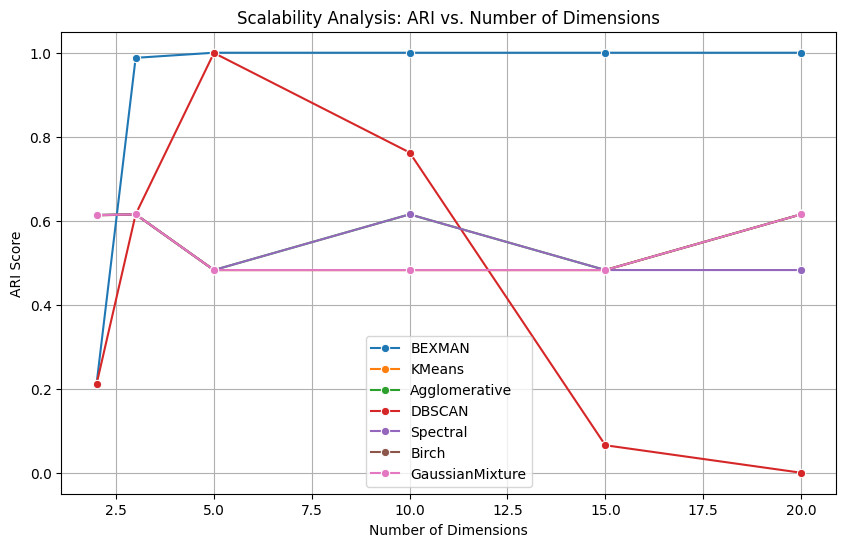

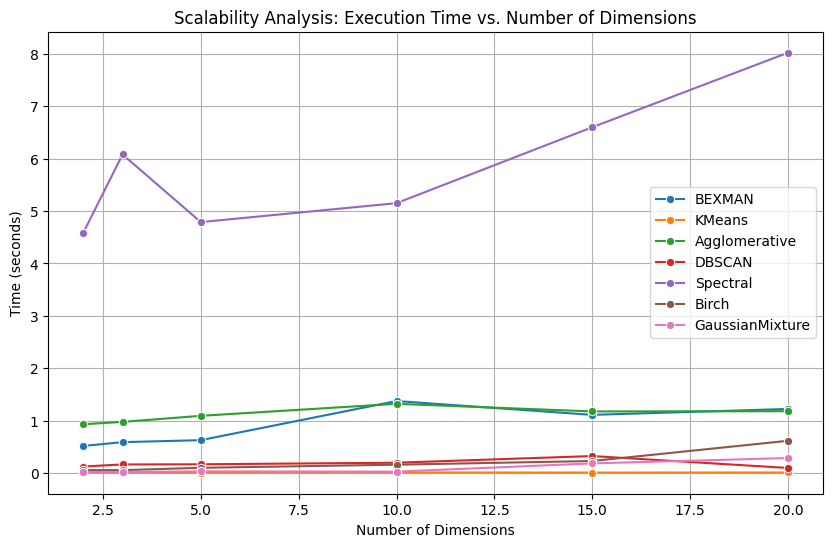

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
import time
import gc

# Dummy RTC implementation (adjusted for 3 clusters)
# class RT:
#     def __init__(self, n_kmeans_clusters=150, k=3, alpha=10.0, sparse_alpha=10,
#                  min_cluster_size=1, gamma=10, beta=-3, ratio_threshold=1):
#         self.n_kmeans_clusters = n_kmeans_clusters
#         self.k = k
#         self.alpha = alpha
#         self.sparse_alpha = sparse_alpha
#         self.min_cluster_size = min_cluster_size
#         self.gamma = gamma
#         self.beta = beta
#         self.ratio_threshold = ratio_threshold
#         self.final_labels = None

#     def fit_predict(self, X):
#         # Here we simply use KMeans with k clusters as a placeholder.
#         km = KMeans(n_clusters=self.k, random_state=42)
#         self.final_labels = km.fit_predict(X)
#         return self.final_labels

# Define clustering algorithms to test.
clustering_algorithms = {
    "BEXMAN": lambda X: RT(n_kmeans_clusters=150, k=3, alpha=10.0, sparse_alpha=10,
                          min_cluster_size=1, gamma=10, beta=-3, ratio_threshold=1).fit_predict(X),
    "KMeans": lambda X: KMeans(n_clusters=3, random_state=42).fit_predict(X),
    "Agglomerative": lambda X: AgglomerativeClustering(n_clusters=3).fit_predict(X),
    "DBSCAN": lambda X: DBSCAN().fit_predict(X),
    "Spectral": lambda X: SpectralClustering(n_clusters=3, random_state=42, assign_labels='discretize').fit_predict(X),
    "Birch": lambda X: Birch(n_clusters=3).fit_predict(X),
    "GaussianMixture": lambda X: GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)
}

# Define different dimensions (number of features) to test.
dimensions_list = [2, 3, 5, 10, 15, 20]
# Fix sample size for each test.
n_samples = 5000

# Store results for each dimension.
results = []

for n_features in dimensions_list:
    print(f"\n🔹 Running scalability test for {n_features} dimensions...")

    # Generate synthetic dataset with fixed number of samples and varying number of features.
    X, y_true = make_blobs(n_samples=n_samples, centers=5, n_features=n_features, random_state=42)
    X = StandardScaler().fit_transform(X)

    scalability_results = {"Dimensions": n_features}

    for algo_name, algo_func in clustering_algorithms.items():
        try:
            start_time = time.time()
            y_pred = algo_func(X)
            elapsed_time = time.time() - start_time

            ari_score = adjusted_rand_score(y_true, y_pred)
            scalability_results[algo_name] = ari_score
            scalability_results[f"{algo_name}_Time"] = elapsed_time

            print(f"  ✅ {algo_name}: ARI = {ari_score:.4f}, Time = {elapsed_time:.2f}s")
        except MemoryError as me:
            print(f"  ❌ MemoryError in {algo_name}: {me}. Skipping this algorithm for {n_features} dimensions.")
            scalability_results[algo_name] = None
            scalability_results[f"{algo_name}_Time"] = None
        except Exception as e:
            print(f"  ❌ Error in {algo_name}: {e}. Skipping this algorithm for {n_features} dimensions.")
            scalability_results[algo_name] = None
            scalability_results[f"{algo_name}_Time"] = None
        finally:
            gc.collect()  # Free up memory

    results.append(scalability_results)

# Convert results to a DataFrame for easy viewing.
df_scalability_dims = pd.DataFrame(results)

# -------------------------
# **Step 1: Display Results as Table**
# -------------------------
print("\n🔹 **Scalability Results for Varying Dimensions (ARI Scores & Execution Time)** 🔹")
display(df_scalability_dims)

# -------------------------
# **Step 2: Plot ARI Scores vs. Dimensions**
# -------------------------
plt.figure(figsize=(10, 6))
for algo_name in clustering_algorithms.keys():
    sns.lineplot(x="Dimensions", y=algo_name, data=df_scalability_dims, marker="o", label=algo_name)
plt.title("Scalability Analysis: ARI vs. Number of Dimensions")
plt.xlabel("Number of Dimensions")
plt.ylabel("ARI Score")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------
# **Step 3: Plot Execution Time vs. Dimensions**
# -------------------------
plt.figure(figsize=(10, 6))
for algo_name in clustering_algorithms.keys():
    sns.lineplot(x="Dimensions", y=f"{algo_name}_Time", data=df_scalability_dims, marker="o", label=algo_name)
plt.title("Scalability Analysis: Execution Time vs. Number of Dimensions")
plt.xlabel("Number of Dimensions")
plt.ylabel("Time (seconds)")
plt.legend()
plt.grid(True)
plt.show()


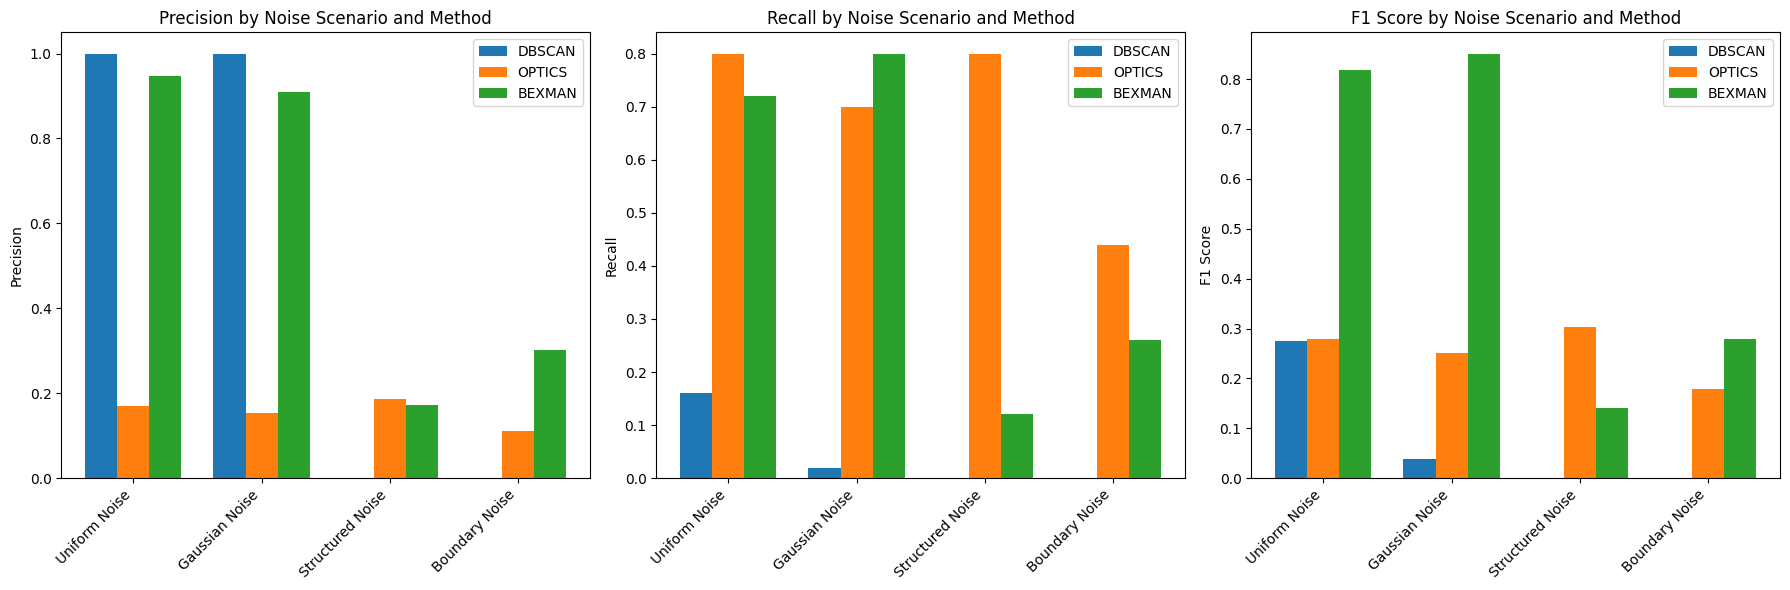

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the scenarios and methods
scenarios = ["Uniform Noise", "Gaussian Noise", "Structured Noise", "Boundary Noise"]
methods = ["DBSCAN", "OPTICS", "BEXMAN"]

# Define the metrics for each scenario (values in order of DBSCAN, OPTICS, RT)
precision = {
    "Uniform Noise": [1.0000, 0.1695, 0.9474],
    "Gaussian Noise": [1.0000, 0.1528, 0.9091],
    "Structured Noise": [0.0000, 0.1869, 0.1714],
    "Boundary Noise": [0.0000, 0.1117, 0.3023]
}

recall = {
    "Uniform Noise": [0.1600, 0.8000, 0.7200],
    "Gaussian Noise": [0.0200, 0.7000, 0.8000],
    "Structured Noise": [0.0000, 0.8000, 0.1200],
    "Boundary Noise": [0.0000, 0.4400, 0.2600]
}

f1 = {
    "Uniform Noise": [0.2759, 0.2797, 0.8182],
    "Gaussian Noise": [0.0392, 0.2509, 0.8511],
    "Structured Noise": [0.0000, 0.3030, 0.1412],
    "Boundary Noise": [0.0000, 0.1781, 0.2796]
}

# Prepare positions for the grouped bar chart
x = np.arange(len(scenarios))  # the label locations
width = 0.25  # width of each bar

# Create subplots for Precision, Recall, and F1 Score
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Precision
ax = axes[0]
for i, method in enumerate(methods):
    ax.bar(x + i * width - width, [precision[sc][i] for sc in scenarios],
           width, label=method)
ax.set_ylabel("Precision")
ax.set_title("Precision by Noise Scenario and Method")
ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=45, ha="right")
ax.legend()

# Plot Recall
ax = axes[1]
for i, method in enumerate(methods):
    ax.bar(x + i * width - width, [recall[sc][i] for sc in scenarios],
           width, label=method)
ax.set_ylabel("Recall")
ax.set_title("Recall by Noise Scenario and Method")
ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=45, ha="right")
ax.legend()

# Plot F1 Score
ax = axes[2]a
for i, method in enumerate(methods):
    ax.bar(x + i * width - width, [f1[sc][i] for sc in scenarios],
           width, label=method)
ax.set_ylabel("F1 Score")
ax.set_title("F1 Score by Noise Scenario and Method")
ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()
